## Configuration & Parameters

Default parameters for manual execution. When run via papermill/batch mode, these will be overridden.

In [155]:
# Parameters Cell (papermill injects values here in batch mode)
# For manual execution, these defaults are used

FOLDER_PATH = r"results_20260127_143906"  # Update this path for manual runs

CSV_FILE_PATH = rf"{FOLDER_PATH}\all_games_minimal.csv"
CSV_INFO_FILE_PATH = rf"{FOLDER_PATH}\simulation_summary.json"

CSV_TYPE = "minimal"  # Options: "full" or "minimal"
INCLUDE_OT_GAMES = True  # Set to False to exclude overtime games

print(f"Analyzing: {FOLDER_PATH}")

Analyzing: results_20260127_143906


In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
from scipy import stats

## HTML Export Utility

This function allows continuous export of analysis results to a single HTML file.

In [157]:
import os
import base64
from io import BytesIO
from datetime import datetime

class HTMLExporter:
    """
    Continuously export analysis results to a single HTML file.
    Supports: text/strings, matplotlib figures, and plotly graphs.
    """
    
    def __init__(self, output_file='analysis_export.html'):
        self.output_file = output_file
        self.is_new_file = not os.path.exists(output_file)
        
        if self.is_new_file:
            self._initialize_html()
    
    def _initialize_html(self):
        """Create a new HTML file with proper structure"""
        html_header = """<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Analysis Export</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            max-width: 1500px;
            margin: 0 auto;
            padding: 20px;
            background-color: #f5f5f5;
        }
        .export-item {
            background: white;
            margin: 20px 0;
            padding: 20px;
            border-radius: 8px;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        }
        .timestamp {
            color: #666;
            font-size: 0.9em;
            margin-bottom: 10px;
        }
        .text-content {
            white-space: pre-wrap;
            font-family: 'Courier New', monospace;
            background: #f8f8f8;
            padding: 15px;
            border-radius: 4px;
            border-left: 4px solid #007acc;
        }
        .plot-container {
            margin: 15px 0;
        }
        h1 {
            color: #333;
            border-bottom: 3px solid #007acc;
            padding-bottom: 10px;
        }
        img {
            max-width: 100%;
            height: auto;
        }
    </style>
</head>
<body>
    <h1>Analysis Export Results</h1>
    <div id="content">
"""
        html_footer = """
    </div>
</body>
</html>"""
        
        with open(self.output_file, 'w', encoding='utf-8') as f:
            f.write(html_header)
            f.write(html_footer)
    
    def _get_timestamp(self):
        """Get current timestamp"""
        return datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    def _fig_to_base64(self, fig):
        """Convert matplotlib figure to base64 string"""
        buffer = BytesIO()
        fig.savefig(buffer, format='png', dpi=150, bbox_inches='tight')
        buffer.seek(0)
        img_str = base64.b64encode(buffer.read()).decode()
        buffer.close()
        return img_str
    
    def export(self, content, title=None):
        """
        Export content to HTML file.
        
        Parameters:
        -----------
        content : str, matplotlib.figure.Figure, or plotly.graph_objs.Figure
            The content to export
        title : str, optional
            A title for this export item
        """
        # Read existing content
        with open(self.output_file, 'r', encoding='utf-8') as f:
            html_content = f.read()
        
        # Find the insertion point (before closing div and body tags)
        insert_pos = html_content.rfind('    </div>')
        
        # Build the new content block
        timestamp = self._get_timestamp()
        new_block = f'\n        <div class="export-item">\n'
        new_block += f'            <div class="timestamp">{timestamp}</div>\n'
        
        if title:
            new_block += f'            <h3>{title}</h3>\n'
        
        # Handle different content types
        if isinstance(content, str):
            # String/text content
            new_block += f'            <div class="text-content">{content}</div>\n'
        
        elif hasattr(content, 'savefig'):
            # Matplotlib figure
            img_data = self._fig_to_base64(content)
            new_block += f'            <div class="plot-container">\n'
            new_block += f'                <img src="data:image/png;base64,{img_data}" alt="Plot"/>\n'
            new_block += f'            </div>\n'
        
        elif hasattr(content, 'to_html'):
            # Plotly figure
            plotly_html = content.to_html(include_plotlyjs=False, div_id=f'plot_{timestamp.replace(" ", "_").replace(":", "-")}')
            new_block += f'            <div class="plot-container">\n'
            new_block += f'                {plotly_html}\n'
            new_block += f'            </div>\n'
        
        else:
            # Fallback: convert to string
            new_block += f'            <div class="text-content">{str(content)}</div>\n'
        
        new_block += '        </div>\n'
        
        # Insert the new block
        new_html = html_content[:insert_pos] + new_block + html_content[insert_pos:]
        
        # Write back to file
        with open(self.output_file, 'w', encoding='utf-8') as f:
            f.write(new_html)
        
        print(f"✓ Exported to {self.output_file}")

# Note: Exporter will be initialized after loading team names and folder path
print("HTMLExporter class loaded!")
print("\nUsage examples:")
print("  exporter.export('Your text here', title='My Analysis')")
print("  exporter.export(fig, title='Matplotlib Plot')")
print("  exporter.export(plotly_fig, title='Interactive Plot')")

HTMLExporter class loaded!

Usage examples:
  exporter.export('Your text here', title='My Analysis')
  exporter.export(fig, title='Matplotlib Plot')
  exporter.export(plotly_fig, title='Interactive Plot')


## Load and Prepare Data

In [158]:
# Load CSV data
df = pd.read_csv(CSV_FILE_PATH, sep=';')

print(f"Loaded {len(df)} rows from {CSV_FILE_PATH}")
print(f"Number of unique games: {df['game_id'].nunique()}")

print("\nColumns in the dataset:")
for col in df.columns:
     print(f" - {col}")

# Load simulation summary information
with open(CSV_INFO_FILE_PATH, 'r') as f:
    sim_summary = json.load(f)

# Labels for teams
t1_label = sim_summary['simulation_config'].get('team1_strategy', 'Team 1')
t2_label = sim_summary['simulation_config'].get('team2_strategy', 'Team 2')

# Initialize exporter with proper naming convention
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
t1_strat = t1_label.replace(' ', '_').replace('-', '_')
t2_strat = t2_label.replace(' ', '_').replace('-', '_')
output_filename = f"{FOLDER_PATH}\\analysis_report_{timestamp}_{t1_strat}_vs_{t2_strat}.html"

exporter = HTMLExporter(output_filename)

print("\nHTMLExporter initialized!")
print(f"Export file: {exporter.output_file}")

# Export data load info
exporter.export(f"""Data Loaded Successfully
{'='*60}
File: {CSV_FILE_PATH}
Total Rows: {len(df)}
Unique Games: {df['game_id'].nunique()}
Team 1: {t1_label}
Team 2: {t2_label}
{'='*60}""", title="Data Loading Summary")


Loaded 2301782 rows from results_20260127_143906\all_games_minimal.csv
Number of unique games: 100000

Columns in the dataset:
 - round_number
 - is_t1_winner
 - is_t1_ct
 - is_ot
 - outcome_reason_code
 - outcome_bomb_planted
 - t1_score_start
 - t1_score_end
 - t1_spent
 - t1_earned
 - t1_funds_start
 - t1_rs_eq
 - t1_fte_eq
 - t1_re_eq
 - t1_survivors
 - t1_consecutive_losses
 - t1_consecutive_losses_start
 - t1_consecutive_wins
 - t1_consecutive_wins_start
 - t1_loss_bonus_level
 - t2_score_start
 - t2_score_end
 - t2_spent
 - t2_earned
 - t2_funds_start
 - t2_rs_eq
 - t2_fte_eq
 - t2_re_eq
 - t2_survivors
 - t2_consecutive_losses
 - t2_consecutive_losses_start
 - t2_consecutive_wins
 - t2_consecutive_wins_start
 - t2_loss_bonus_level
 - game_id

HTMLExporter initialized!
Export file: results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html
✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html


## Filter Data

In [159]:

# Apply OT filter

if not INCLUDE_OT_GAMES:
    df_filtered = df[df['is_ot'] == False].copy()
else:
    df_filtered = df.copy()


filter_text = f"""Data Filtering Results
 Games after filter: {df_filtered['game_id'].nunique()} / {df['game_id'].nunique()}
 Percentage of remaining games: {df_filtered['game_id'].nunique() / df['game_id'].nunique() * 100:.2f}%
 
 Total Rows after filter: {len(df_filtered)}
 Rounds with OT: {df_filtered['is_ot'].sum()}
 Rounds without OT: {(~df_filtered['is_ot']).sum()}
"""

print(filter_text)

exporter.export(filter_text, title="Data Filter Summary")

Data Filtering Results
 Games after filter: 100000 / 100000
 Percentage of remaining games: 100.00%

 Total Rows after filter: 2301782
 Rounds with OT: 127990
 Rounds without OT: 2173792

✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html


## Data Summary Statistics

In [160]:



# Team 1 statistics
economic_summary = f"""
{t1_label}: 
  Starting Funds:
{df_filtered['t1_funds_start'].describe().apply(lambda x: f"{x:,.2f}").to_string()}
  FTE Equipment:
{df_filtered['t1_fte_eq'].describe().apply(lambda x: f"{x:,.2f}").to_string()}
  Spent per Round:
{df_filtered['t1_spent'].describe().apply(lambda x: f"{x:,.2f}").to_string()}
  Earned per Round:
{df_filtered['t1_earned'].describe().apply(lambda x: f"{x:,.2f}").to_string()}

{"=" * 60}

{t2_label}: 
  Starting Funds:
{df_filtered['t2_funds_start'].describe().apply(lambda x: f"{x:,.2f}").to_string()}
  FTE Equipment:
{df_filtered['t2_fte_eq'].describe().apply(lambda x: f"{x:,.2f}").to_string()}
  Spent per Round:
{df_filtered['t2_spent'].describe().apply(lambda x: f"{x:,.2f}").to_string()}
  Earned per Round:
{df_filtered['t2_earned'].describe().apply(lambda x: f"{x:,.2f}").to_string()}
"""
print(economic_summary)


exporter.export(economic_summary, title="Economic Metrics Summary")


all_in: 
  Starting Funds:
count    2,301,782.00
mean        15,357.06
std          5,157.55
min          4,000.00
25%         12,600.00
50%         17,750.00
75%         18,050.00
max         50,000.00
  FTE Equipment:
count    2,301,782.00
mean        26,026.20
std         13,800.18
min          5,000.00
25%         14,031.00
50%         25,629.00
75%         35,488.00
max        144,653.00
  Spent per Round:
count    2,301,782.00
mean        15,357.06
std          5,157.55
min          4,000.00
25%         12,600.00
50%         17,750.00
75%         18,050.00
max         50,000.00
  Earned per Round:
count    2,301,782.00
mean        16,395.35
std          3,352.81
min          5,600.00
25%         17,000.00
50%         17,750.00
75%         18,050.00
max         22,800.00


xen_model: 
  Starting Funds:
count    2,301,782.00
mean        41,119.53
std         26,629.97
min          4,000.00
25%         18,050.00
50%         34,900.00
75%         69,100.00
max         80,000.00
  FT

In [161]:
#TODO: spenditure boxplot and ratio to available funds -> more?



### FTE Equipment Ratio Analysis

Analyzing the ratio of FTE equipment to available funds for both teams.

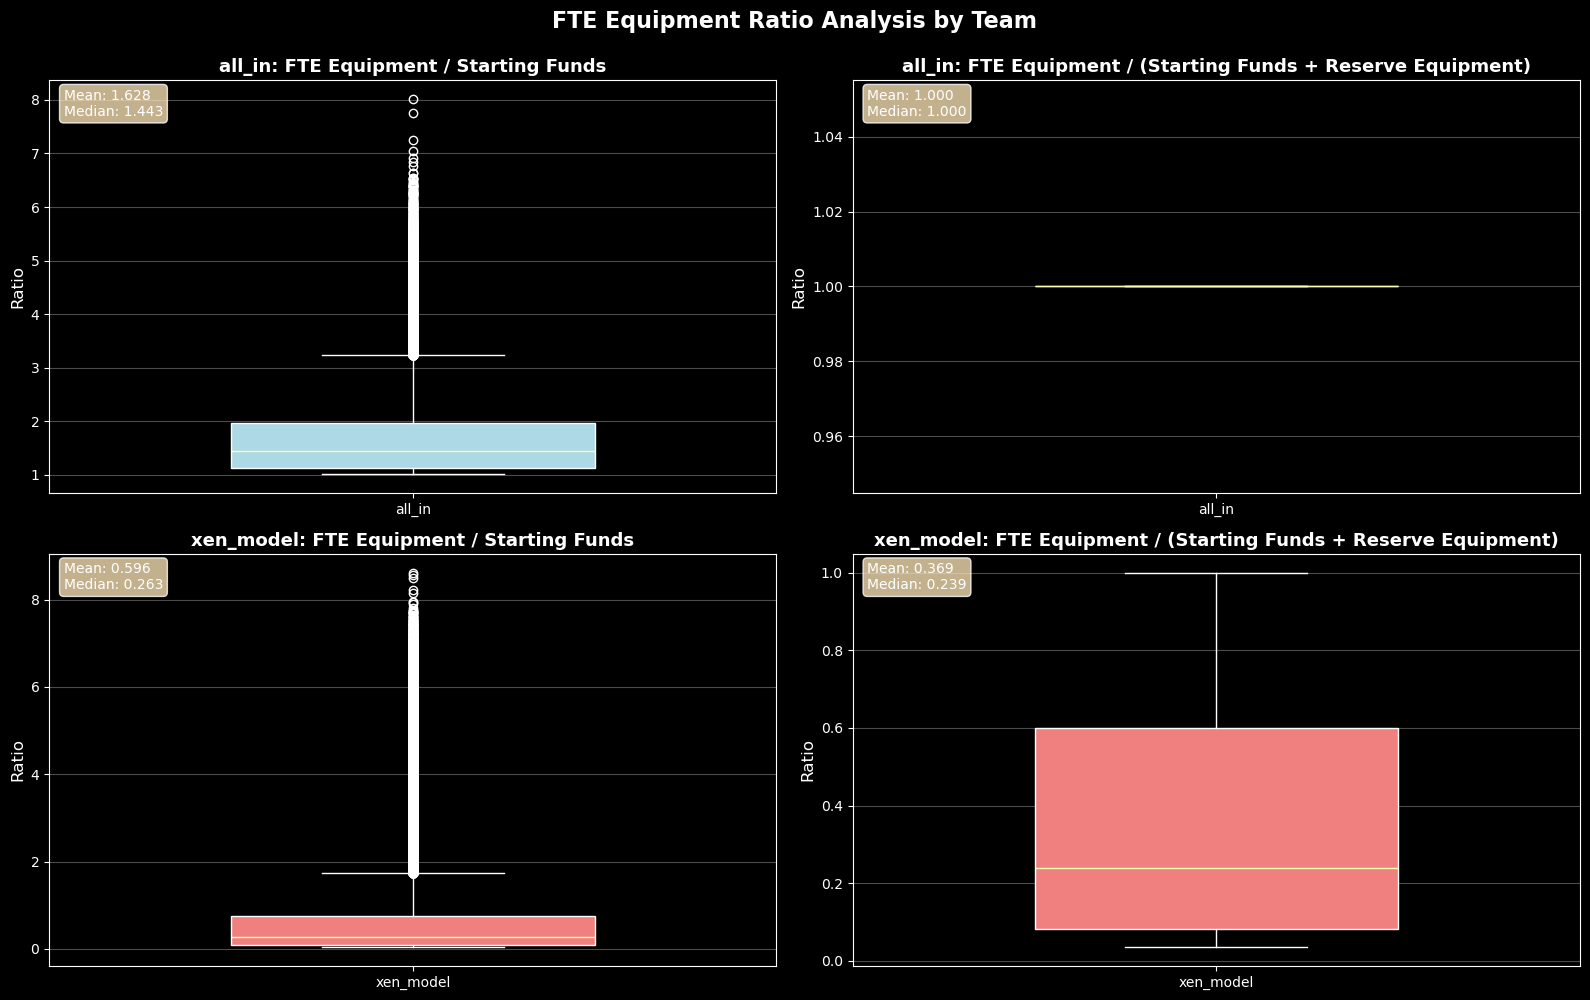

✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html
✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html


In [162]:
# Calculate FTE equipment ratios for both teams

# Team 1 ratios
t1_fte_to_funds_start = df_filtered['t1_fte_eq'] / df_filtered['t1_funds_start']
t1_fte_to_total_funds = df_filtered['t1_fte_eq'] / (df_filtered['t1_funds_start'] + df_filtered['t1_rs_eq'])

# Team 2 ratios
t2_fte_to_funds_start = df_filtered['t2_fte_eq'] / df_filtered['t2_funds_start']
t2_fte_to_total_funds = df_filtered['t2_fte_eq'] / (df_filtered['t2_funds_start'] + df_filtered['t2_rs_eq'])

# ============================================================================
# FIGURE: FTE EQUIPMENT RATIO BOXPLOTS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Team 1 - FTE/Funds_Start
bp1 = axes[0, 0].boxplot([t1_fte_to_funds_start.dropna()], 
                          tick_labels=[t1_label],
                          patch_artist=True,
                          widths=0.5)
bp1['boxes'][0].set_facecolor('lightblue')
axes[0, 0].set_ylabel('Ratio', fontsize=12)
axes[0, 0].set_title(f'{t1_label}: FTE Equipment / Starting Funds', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Add statistics
mean_val = t1_fte_to_funds_start.mean()
median_val = t1_fte_to_funds_start.median()
axes[0, 0].text(0.02, 0.98, f'Mean: {mean_val:.3f}\nMedian: {median_val:.3f}',
                transform=axes[0, 0].transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                fontsize=10)

# Team 1 - FTE/(Funds_Start + RS_EQ)
bp2 = axes[0, 1].boxplot([t1_fte_to_total_funds.dropna()], 
                          tick_labels=[t1_label],
                          patch_artist=True,
                          widths=0.5)
bp2['boxes'][0].set_facecolor('lightblue')
axes[0, 1].set_ylabel('Ratio', fontsize=12)
axes[0, 1].set_title(f'{t1_label}: FTE Equipment / (Starting Funds + Reserve Equipment)', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Add statistics
mean_val = t1_fte_to_total_funds.mean()
median_val = t1_fte_to_total_funds.median()
axes[0, 1].text(0.02, 0.98, f'Mean: {mean_val:.3f}\nMedian: {median_val:.3f}',
                transform=axes[0, 1].transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                fontsize=10)

# Team 2 - FTE/Funds_Start
bp3 = axes[1, 0].boxplot([t2_fte_to_funds_start.dropna()], 
                          tick_labels=[t2_label],
                          patch_artist=True,
                          widths=0.5)
bp3['boxes'][0].set_facecolor('lightcoral')
axes[1, 0].set_ylabel('Ratio', fontsize=12)
axes[1, 0].set_title(f'{t2_label}: FTE Equipment / Starting Funds', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Add statistics
mean_val = t2_fte_to_funds_start.mean()
median_val = t2_fte_to_funds_start.median()
axes[1, 0].text(0.02, 0.98, f'Mean: {mean_val:.3f}\nMedian: {median_val:.3f}',
                transform=axes[1, 0].transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                fontsize=10)

# Team 2 - FTE/(Funds_Start + RS_EQ)
bp4 = axes[1, 1].boxplot([t2_fte_to_total_funds.dropna()], 
                          tick_labels=[t2_label],
                          patch_artist=True,
                          widths=0.5)
bp4['boxes'][0].set_facecolor('lightcoral')
axes[1, 1].set_ylabel('Ratio', fontsize=12)
axes[1, 1].set_title(f'{t2_label}: FTE Equipment / (Starting Funds + Reserve Equipment)', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# Add statistics
mean_val = t2_fte_to_total_funds.mean()
median_val = t2_fte_to_total_funds.median()
axes[1, 1].text(0.02, 0.98, f'Mean: {mean_val:.3f}\nMedian: {median_val:.3f}',
                transform=axes[1, 1].transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                fontsize=10)

fig.suptitle('FTE Equipment Ratio Analysis by Team', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

exporter.export(fig, title="FTE Equipment Ratio Analysis - Boxplots")



fte_stats_text = f""" 
 FTE EQUIPMENT RATIO STATISTICS
 {t1_label}:
   FTE/Starting Funds:
     Mean={t1_fte_to_funds_start.mean():.3f}, Median={t1_fte_to_funds_start.median():.3f}
     Q1 (25%)={t1_fte_to_funds_start.quantile(0.25):.3f}, Q3 (75%)={t1_fte_to_funds_start.quantile(0.75):.3f}
     Min={t1_fte_to_funds_start.min():.3f}, Max={t1_fte_to_funds_start.max():.3f}
   FTE/Total Funds (inc. RS):
     Mean={t1_fte_to_total_funds.mean():.3f}, Median={t1_fte_to_total_funds.median():.3f}
     Q1 (25%)={t1_fte_to_total_funds.quantile(0.25):.3f}, Q3 (75%)={t1_fte_to_total_funds.quantile(0.75):.3f}
     Min={t1_fte_to_total_funds.min():.3f}, Max={t1_fte_to_total_funds.max():.3f}
 {t2_label}:
   FTE/Starting Funds:
     Mean={t2_fte_to_funds_start.mean():.3f}, Median={t2_fte_to_funds_start.median():.3f}
     Q1 (25%)={t2_fte_to_funds_start.quantile(0.25):.3f}, Q3 (75%)={t2_fte_to_funds_start.quantile(0.75):.3f}
     Min={t2_fte_to_funds_start.min():.3f}, Max={t2_fte_to_funds_start.max():.3f}
   FTE/Total Funds (inc. RS):
     Mean={t2_fte_to_total_funds.mean():.3f}, Median={t2_fte_to_total_funds.median():.3f}
     Q1 (25%)={t2_fte_to_total_funds.quantile(0.25):.3f}, Q3 (75%)={t2_fte_to_total_funds.quantile(0.75):.3f}
     Min={t2_fte_to_total_funds.min():.3f}, Max={t2_fte_to_total_funds.max():.3f}
"""




exporter.export(fte_stats_text, title="FTE Ratio Statistics")

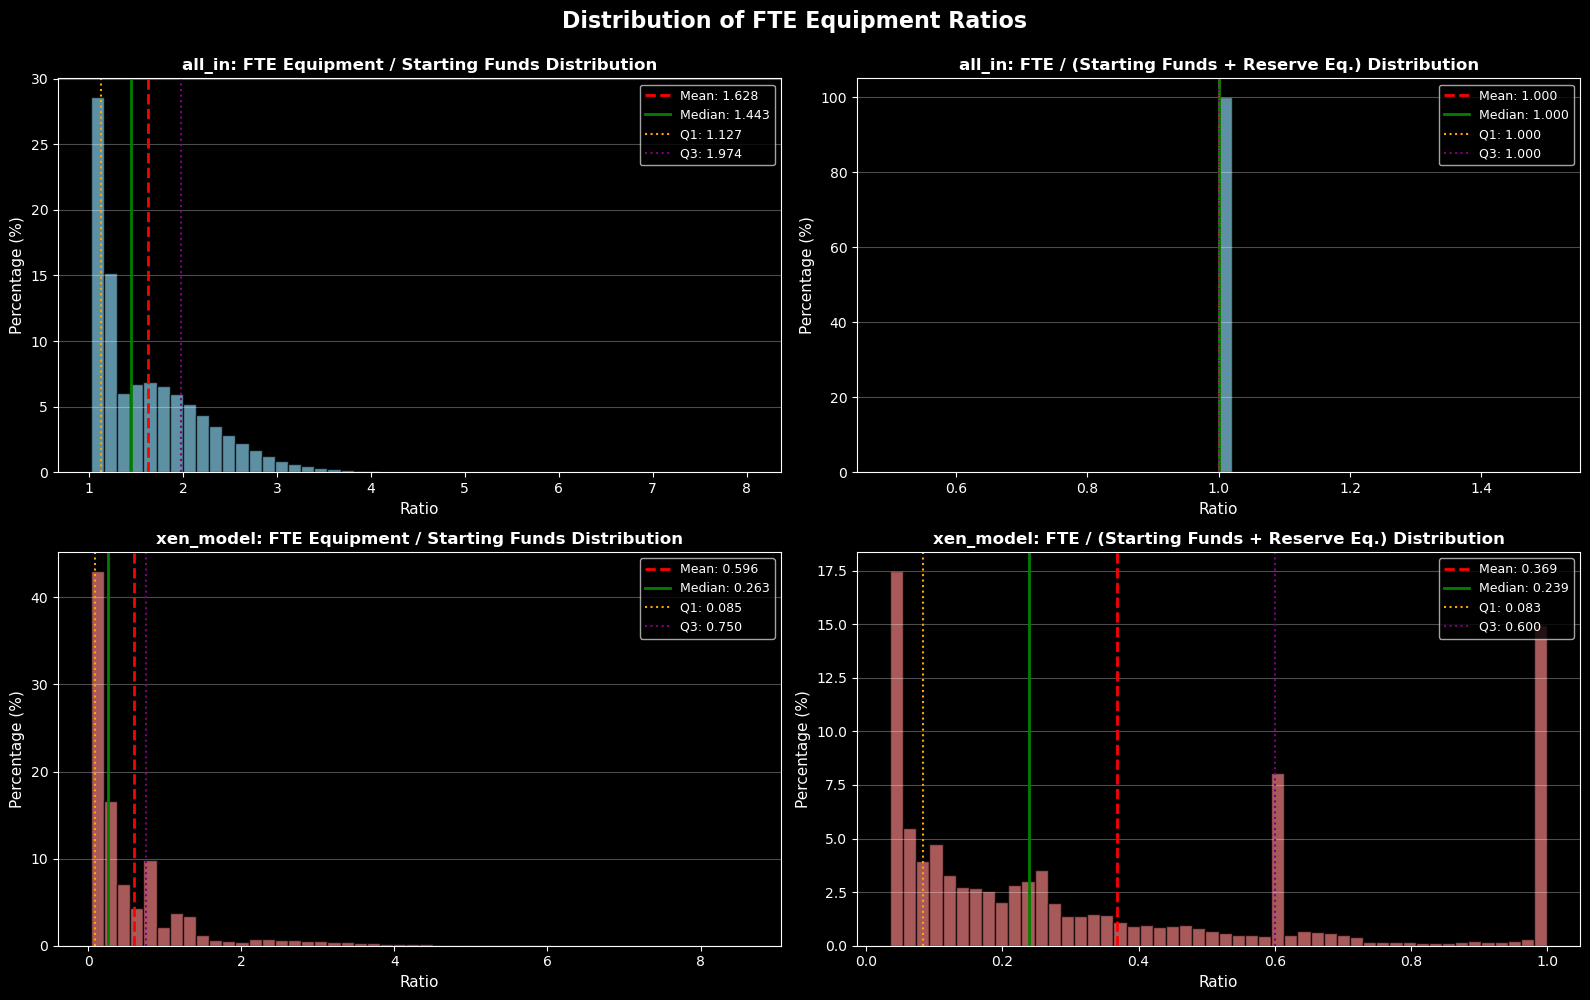

✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html


In [163]:
# ============================================================================
# DISTRIBUTION PLOTS FOR FTE EQUIPMENT RATIOS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Team 1 - FTE/Funds_Start Distribution
t1_data = t1_fte_to_funds_start.dropna()
weights1 = np.ones_like(t1_data) * (100.0 / len(t1_data))
axes[0, 0].hist(t1_data, bins=50, weights=weights1, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(t1_fte_to_funds_start.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {t1_fte_to_funds_start.mean():.3f}')
axes[0, 0].axvline(t1_fte_to_funds_start.median(), color='green', linestyle='-', linewidth=2, label=f'Median: {t1_fte_to_funds_start.median():.3f}')
axes[0, 0].axvline(t1_fte_to_funds_start.quantile(0.25), color='orange', linestyle=':', linewidth=1.5, label=f'Q1: {t1_fte_to_funds_start.quantile(0.25):.3f}')
axes[0, 0].axvline(t1_fte_to_funds_start.quantile(0.75), color='purple', linestyle=':', linewidth=1.5, label=f'Q3: {t1_fte_to_funds_start.quantile(0.75):.3f}')
axes[0, 0].set_xlabel('Ratio', fontsize=11)
axes[0, 0].set_ylabel('Percentage (%)', fontsize=11)
axes[0, 0].set_title(f'{t1_label}: FTE Equipment / Starting Funds Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(axis='y', alpha=0.3)

# Team 1 - FTE/Total Funds Distribution
t1_data2 = t1_fte_to_total_funds.dropna()
weights2 = np.ones_like(t1_data2) * (100.0 / len(t1_data2))
axes[0, 1].hist(t1_data2, bins=50, weights=weights2, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].axvline(t1_fte_to_total_funds.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {t1_fte_to_total_funds.mean():.3f}')
axes[0, 1].axvline(t1_fte_to_total_funds.median(), color='green', linestyle='-', linewidth=2, label=f'Median: {t1_fte_to_total_funds.median():.3f}')
axes[0, 1].axvline(t1_fte_to_total_funds.quantile(0.25), color='orange', linestyle=':', linewidth=1.5, label=f'Q1: {t1_fte_to_total_funds.quantile(0.25):.3f}')
axes[0, 1].axvline(t1_fte_to_total_funds.quantile(0.75), color='purple', linestyle=':', linewidth=1.5, label=f'Q3: {t1_fte_to_total_funds.quantile(0.75):.3f}')
axes[0, 1].set_xlabel('Ratio', fontsize=11)
axes[0, 1].set_ylabel('Percentage (%)', fontsize=11)
axes[0, 1].set_title(f'{t1_label}: FTE / (Starting Funds + Reserve Eq.) Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

# Team 2 - FTE/Funds_Start Distribution
t2_data = t2_fte_to_funds_start.dropna()
weights3 = np.ones_like(t2_data) * (100.0 / len(t2_data))
axes[1, 0].hist(t2_data, bins=50, weights=weights3, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 0].axvline(t2_fte_to_funds_start.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {t2_fte_to_funds_start.mean():.3f}')
axes[1, 0].axvline(t2_fte_to_funds_start.median(), color='green', linestyle='-', linewidth=2, label=f'Median: {t2_fte_to_funds_start.median():.3f}')
axes[1, 0].axvline(t2_fte_to_funds_start.quantile(0.25), color='orange', linestyle=':', linewidth=1.5, label=f'Q1: {t2_fte_to_funds_start.quantile(0.25):.3f}')
axes[1, 0].axvline(t2_fte_to_funds_start.quantile(0.75), color='purple', linestyle=':', linewidth=1.5, label=f'Q3: {t2_fte_to_funds_start.quantile(0.75):.3f}')
axes[1, 0].set_xlabel('Ratio', fontsize=11)
axes[1, 0].set_ylabel('Percentage (%)', fontsize=11)
axes[1, 0].set_title(f'{t2_label}: FTE Equipment / Starting Funds Distribution', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(axis='y', alpha=0.3)

# Team 2 - FTE/Total Funds Distribution
t2_data2 = t2_fte_to_total_funds.dropna()
weights4 = np.ones_like(t2_data2) * (100.0 / len(t2_data2))
axes[1, 1].hist(t2_data2, bins=50, weights=weights4, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 1].axvline(t2_fte_to_total_funds.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {t2_fte_to_total_funds.mean():.3f}')
axes[1, 1].axvline(t2_fte_to_total_funds.median(), color='green', linestyle='-', linewidth=2, label=f'Median: {t2_fte_to_total_funds.median():.3f}')
axes[1, 1].axvline(t2_fte_to_total_funds.quantile(0.25), color='orange', linestyle=':', linewidth=1.5, label=f'Q1: {t2_fte_to_total_funds.quantile(0.25):.3f}')
axes[1, 1].axvline(t2_fte_to_total_funds.quantile(0.75), color='purple', linestyle=':', linewidth=1.5, label=f'Q3: {t2_fte_to_total_funds.quantile(0.75):.3f}')
axes[1, 1].set_xlabel('Ratio', fontsize=11)
axes[1, 1].set_ylabel('Percentage (%)', fontsize=11)
axes[1, 1].set_title(f'{t2_label}: FTE / (Starting Funds + Reserve Eq.) Distribution', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(axis='y', alpha=0.3)

fig.suptitle('Distribution of FTE Equipment Ratios', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

exporter.export(fig, title="FTE Equipment Ratio Distributions")


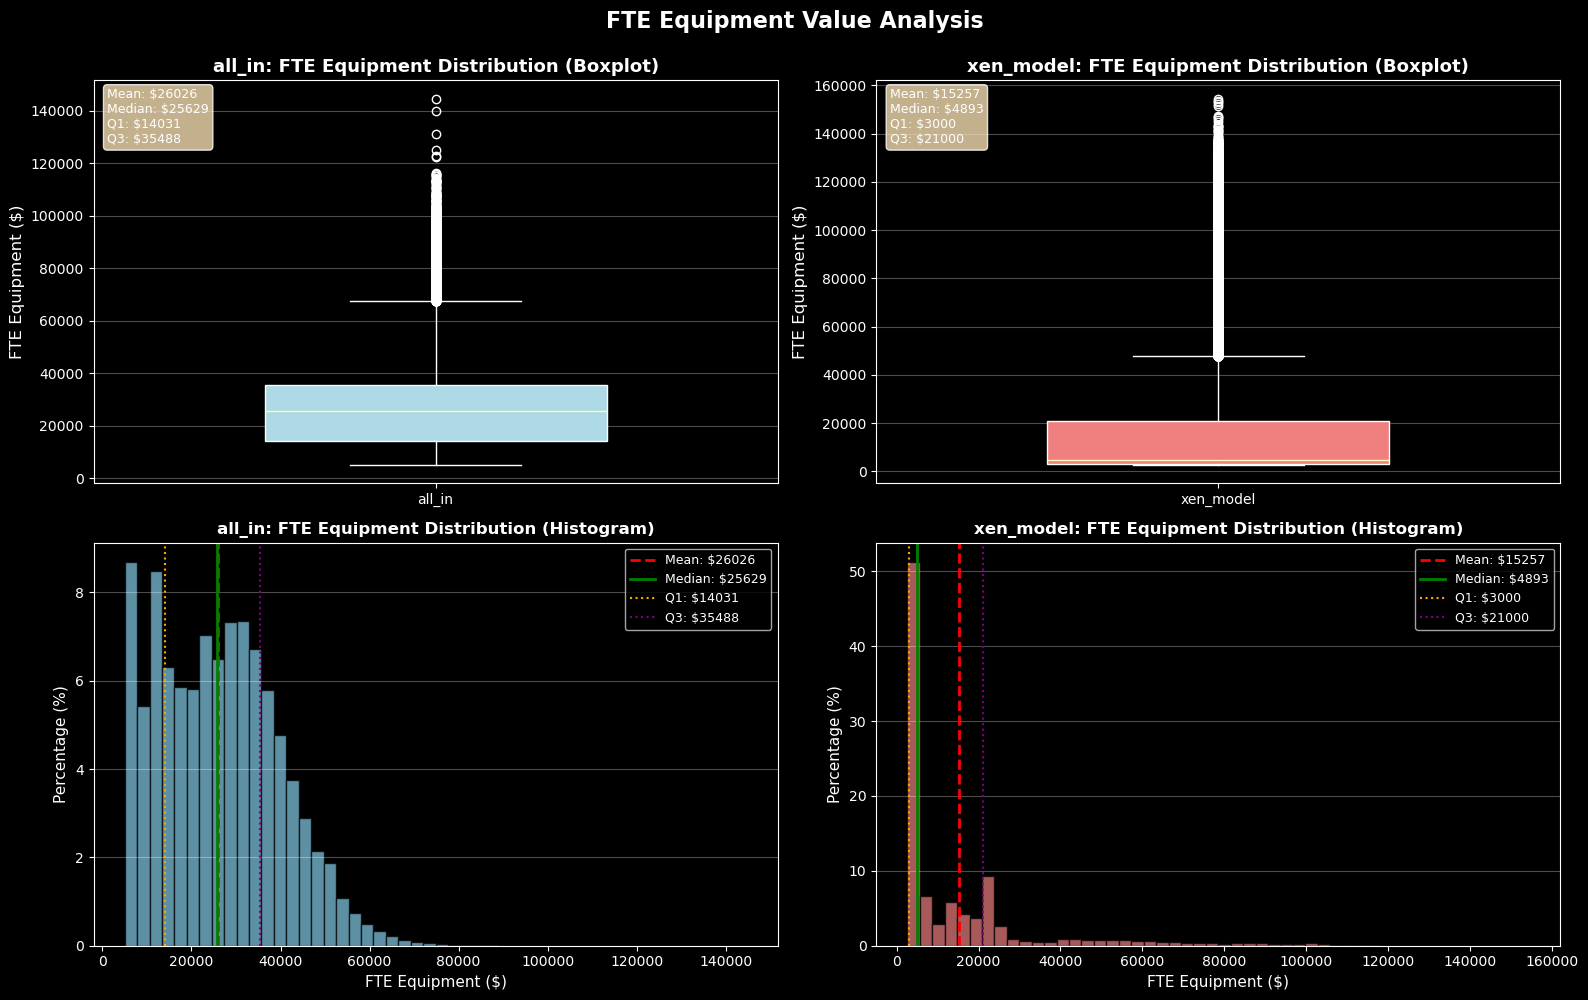

✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html

 FTE EQUIPMENT VALUE STATISTICS")
 all_in:
   Mean: $26026.20
   Median: $25629.00
   Q1 (25%): $14031.00
   Q3 (75%): $35488.00
   Min: $5000.00
   Max: $144653.00
   Std Dev: $13800.18
 xen_model:
   Mean: $15256.65
   Median: $4893.00
   Q1 (25%): $3000.00
   Q3 (75%): $21000.00
   Min: $2622.00
   Max: $154496.00
   Std Dev: $20269.57

✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html


In [164]:
# ============================================================================
# FTE EQUIPMENT VALUES - BOXPLOT AND DISTRIBUTION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Extract FTE equipment values
t1_fte_eq = df_filtered['t1_fte_eq']
t2_fte_eq = df_filtered['t2_fte_eq']

# Row 1: Boxplots
# Team 1 Boxplot
bp1 = axes[0, 0].boxplot([t1_fte_eq.dropna()], 
                          tick_labels=[t1_label],
                          patch_artist=True,
                          widths=0.5)
bp1['boxes'][0].set_facecolor('lightblue')
axes[0, 0].set_ylabel('FTE Equipment ($)', fontsize=12)
axes[0, 0].set_title(f'{t1_label}: FTE Equipment Distribution (Boxplot)', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Add statistics
mean_val = t1_fte_eq.mean()
median_val = t1_fte_eq.median()
q1_val = t1_fte_eq.quantile(0.25)
q3_val = t1_fte_eq.quantile(0.75)
axes[0, 0].text(0.02, 0.98, 
                f'Mean: ${mean_val:.0f}\nMedian: ${median_val:.0f}\nQ1: ${q1_val:.0f}\nQ3: ${q3_val:.0f}',
                transform=axes[0, 0].transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                fontsize=9)

# Team 2 Boxplot
bp2 = axes[0, 1].boxplot([t2_fte_eq.dropna()], 
                          tick_labels=[t2_label],
                          patch_artist=True,
                          widths=0.5)
bp2['boxes'][0].set_facecolor('lightcoral')
axes[0, 1].set_ylabel('FTE Equipment ($)', fontsize=12)
axes[0, 1].set_title(f'{t2_label}: FTE Equipment Distribution (Boxplot)', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Add statistics
mean_val = t2_fte_eq.mean()
median_val = t2_fte_eq.median()
q1_val = t2_fte_eq.quantile(0.25)
q3_val = t2_fte_eq.quantile(0.75)
axes[0, 1].text(0.02, 0.98, 
                f'Mean: ${mean_val:.0f}\nMedian: ${median_val:.0f}\nQ1: ${q1_val:.0f}\nQ3: ${q3_val:.0f}',
                transform=axes[0, 1].transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                fontsize=9)

# Row 2: Distribution Histograms
# Team 1 Distribution
t1_fte_data = t1_fte_eq.dropna()
fte_weights1 = np.ones_like(t1_fte_data) * (100.0 / len(t1_fte_data))
axes[1, 0].hist(t1_fte_data, bins=50, weights=fte_weights1, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].axvline(t1_fte_eq.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${t1_fte_eq.mean():.0f}')
axes[1, 0].axvline(t1_fte_eq.median(), color='green', linestyle='-', linewidth=2, label=f'Median: ${t1_fte_eq.median():.0f}')
axes[1, 0].axvline(t1_fte_eq.quantile(0.25), color='orange', linestyle=':', linewidth=1.5, label=f'Q1: ${t1_fte_eq.quantile(0.25):.0f}')
axes[1, 0].axvline(t1_fte_eq.quantile(0.75), color='purple', linestyle=':', linewidth=1.5, label=f'Q3: ${t1_fte_eq.quantile(0.75):.0f}')
axes[1, 0].set_xlabel('FTE Equipment ($)', fontsize=11)
axes[1, 0].set_ylabel('Percentage (%)', fontsize=11)
axes[1, 0].set_title(f'{t1_label}: FTE Equipment Distribution (Histogram)', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(axis='y', alpha=0.3)

# Team 2 Distribution
t2_fte_data = t2_fte_eq.dropna()
fte_weights2 = np.ones_like(t2_fte_data) * (100.0 / len(t2_fte_data))
axes[1, 1].hist(t2_fte_data, bins=50, weights=fte_weights2, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 1].axvline(t2_fte_eq.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${t2_fte_eq.mean():.0f}')
axes[1, 1].axvline(t2_fte_eq.median(), color='green', linestyle='-', linewidth=2, label=f'Median: ${t2_fte_eq.median():.0f}')
axes[1, 1].axvline(t2_fte_eq.quantile(0.25), color='orange', linestyle=':', linewidth=1.5, label=f'Q1: ${t2_fte_eq.quantile(0.25):.0f}')
axes[1, 1].axvline(t2_fte_eq.quantile(0.75), color='purple', linestyle=':', linewidth=1.5, label=f'Q3: ${t2_fte_eq.quantile(0.75):.0f}')
axes[1, 1].set_xlabel('FTE Equipment ($)', fontsize=11)
axes[1, 1].set_ylabel('Percentage (%)', fontsize=11)
axes[1, 1].set_title(f'{t2_label}: FTE Equipment Distribution (Histogram)', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(axis='y', alpha=0.3)

fig.suptitle('FTE Equipment Value Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

exporter.export(fig, title="FTE Equipment Value Analysis")


fte_value_stats = f"""
 FTE EQUIPMENT VALUE STATISTICS")
 {t1_label}:
   Mean: ${t1_fte_eq.mean():.2f}
   Median: ${t1_fte_eq.median():.2f}
   Q1 (25%): ${t1_fte_eq.quantile(0.25):.2f}
   Q3 (75%): ${t1_fte_eq.quantile(0.75):.2f}
   Min: ${t1_fte_eq.min():.2f}
   Max: ${t1_fte_eq.max():.2f}
   Std Dev: ${t1_fte_eq.std():.2f}
 {t2_label}:
   Mean: ${t2_fte_eq.mean():.2f}
   Median: ${t2_fte_eq.median():.2f}
   Q1 (25%): ${t2_fte_eq.quantile(0.25):.2f}
   Q3 (75%): ${t2_fte_eq.quantile(0.75):.2f}
   Min: ${t2_fte_eq.min():.2f}
   Max: ${t2_fte_eq.max():.2f}
   Std Dev: ${t2_fte_eq.std():.2f}
"""
print(fte_value_stats)

exporter.export(fte_value_stats, title="FTE Equipment Statistics")

### Length of game

In [165]:
# Score lengths and scoreline percentages (non-OT, using df_filtered/last_scores)

# Use existing per-game final scores if available, otherwise compute from df_filtered


scores = (
    df_filtered.sort_values(['game_id', 'round_number'])
    .groupby('game_id')
    .agg(t1_final=('t1_score_end', 'last'), t2_final=('t2_score_end', 'last'))
)



# Prepare helpers
scores['total_rounds'] = scores['t1_final'] + scores['t2_final']
scores['higher'] = scores[['t1_final', 't2_final']].max(axis=1)
scores['lower'] = scores[['t1_final', 't2_final']].min(axis=1)
scores['canon'] = scores['higher'].astype(int).astype(str) + ':' + scores['lower'].astype(int).astype(str)  # e.g., "16:14"
t1_won_mask = scores['t1_final'] > scores['t2_final']
t2_won_mask = ~t1_won_mask


# 2) Overall canonical scorelines (treat 16:14 = 14:16)
canon_overall = (
    scores.groupby(['higher', 'lower', 'canon'])
    .size()
    .reset_index(name='count')
)
canon_overall['total_rounds'] = canon_overall['higher'] + canon_overall['lower']
canon_overall['pct'] = (canon_overall['count'] / len(scores) * 100).round(2)
canon_overall = canon_overall.sort_values(['total_rounds', 'higher', 'lower']).set_index('canon')[['count', 'pct', 'total_rounds']]

# 3) Score lengths by team (winner-only), side by side
_length_t1 = scores.loc[t1_won_mask, 'total_rounds'].value_counts()
_length_t2 = scores.loc[t2_won_mask, 'total_rounds'].value_counts()
length_by_team = pd.DataFrame({
    f'{t1_label}_count': _length_t1,
    f'{t2_label}_count': _length_t2
}).fillna(0).astype(int).sort_index()
length_by_team[f'{t1_label}_pct'] = (length_by_team[f'{t1_label}_count'] / t1_won_mask.sum() * 100).round(5)
length_by_team[f'{t1_label}_cumulative_pct'] = length_by_team[f'{t1_label}_pct'].cumsum()
length_by_team[f'{t2_label}_pct'] = (length_by_team[f'{t2_label}_count'] / t2_won_mask.sum() * 100).round(5)
length_by_team[f'{t2_label}_cumulative_pct'] = length_by_team[f'{t2_label}_pct'].cumsum()

# 4) Canonical scorelines by team (winner-only), side by side
_canon_t1 = scores.loc[t1_won_mask, 'canon'].value_counts()
_canon_t2 = scores.loc[t2_won_mask, 'canon'].value_counts()
canon_by_team = pd.DataFrame({
    f'{t1_label}_count': _canon_t1,
    f'{t2_label}_count': _canon_t2
}).fillna(0).astype(int)

# Add percentages per team (normalize within each team's wins)
canon_by_team[f'{t1_label}_pct'] = (canon_by_team[f'{t1_label}_count'] / t1_won_mask.sum() * 100).round(5)
canon_by_team[f'{t2_label}_pct'] = (canon_by_team[f'{t2_label}_count'] / t2_won_mask.sum() * 100).round(5)
canon_by_team[f'{t1_label}_cumulative_pct'] = canon_by_team[f'{t1_label}_pct'].cumsum()
canon_by_team[f'{t2_label}_cumulative_pct'] = canon_by_team[f'{t2_label}_pct'].cumsum()

canon_overall['cumulative_pct'] = canon_overall['pct'].cumsum()


# Display
game_length_text = f"""Game Length and Scoreline Analysis
Overall canonical scorelines (winner:loser):")
{canon_overall[['total_rounds','count', 'pct', 'cumulative_pct']].to_string()}

 Overall score lengths by team (winner-only): [{t1_label} vs {t2_label}]")
{length_by_team.to_string()}
"""
print(game_length_text)
exporter.export(game_length_text, title="Game Length and Scoreline Analysis")

Game Length and Scoreline Analysis
Overall canonical scorelines (winner:loser):")
       total_rounds  count   pct  cumulative_pct
canon                                           
16:0             16   4418  4.42            4.42
16:1             17   6127  6.13           10.55
16:2             18   6753  6.75           17.30
16:3             19   7528  7.53           24.83
16:4             20   8128  8.13           32.96
16:5             21   8332  8.33           41.29
16:6             22   8287  8.29           49.58
16:7             23   7983  7.98           57.56
16:8             24   7419  7.42           64.98
16:9             25   6786  6.79           71.77
16:10            26   6077  6.08           77.85
16:11            27   5409  5.41           83.26
16:12            28   4737  4.74           88.00
16:13            29   4283  4.28           92.28
16:14            30   4077  4.08           96.36
19:15            34   2396  2.40           98.76
19:16            35    534  0.53    

✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html


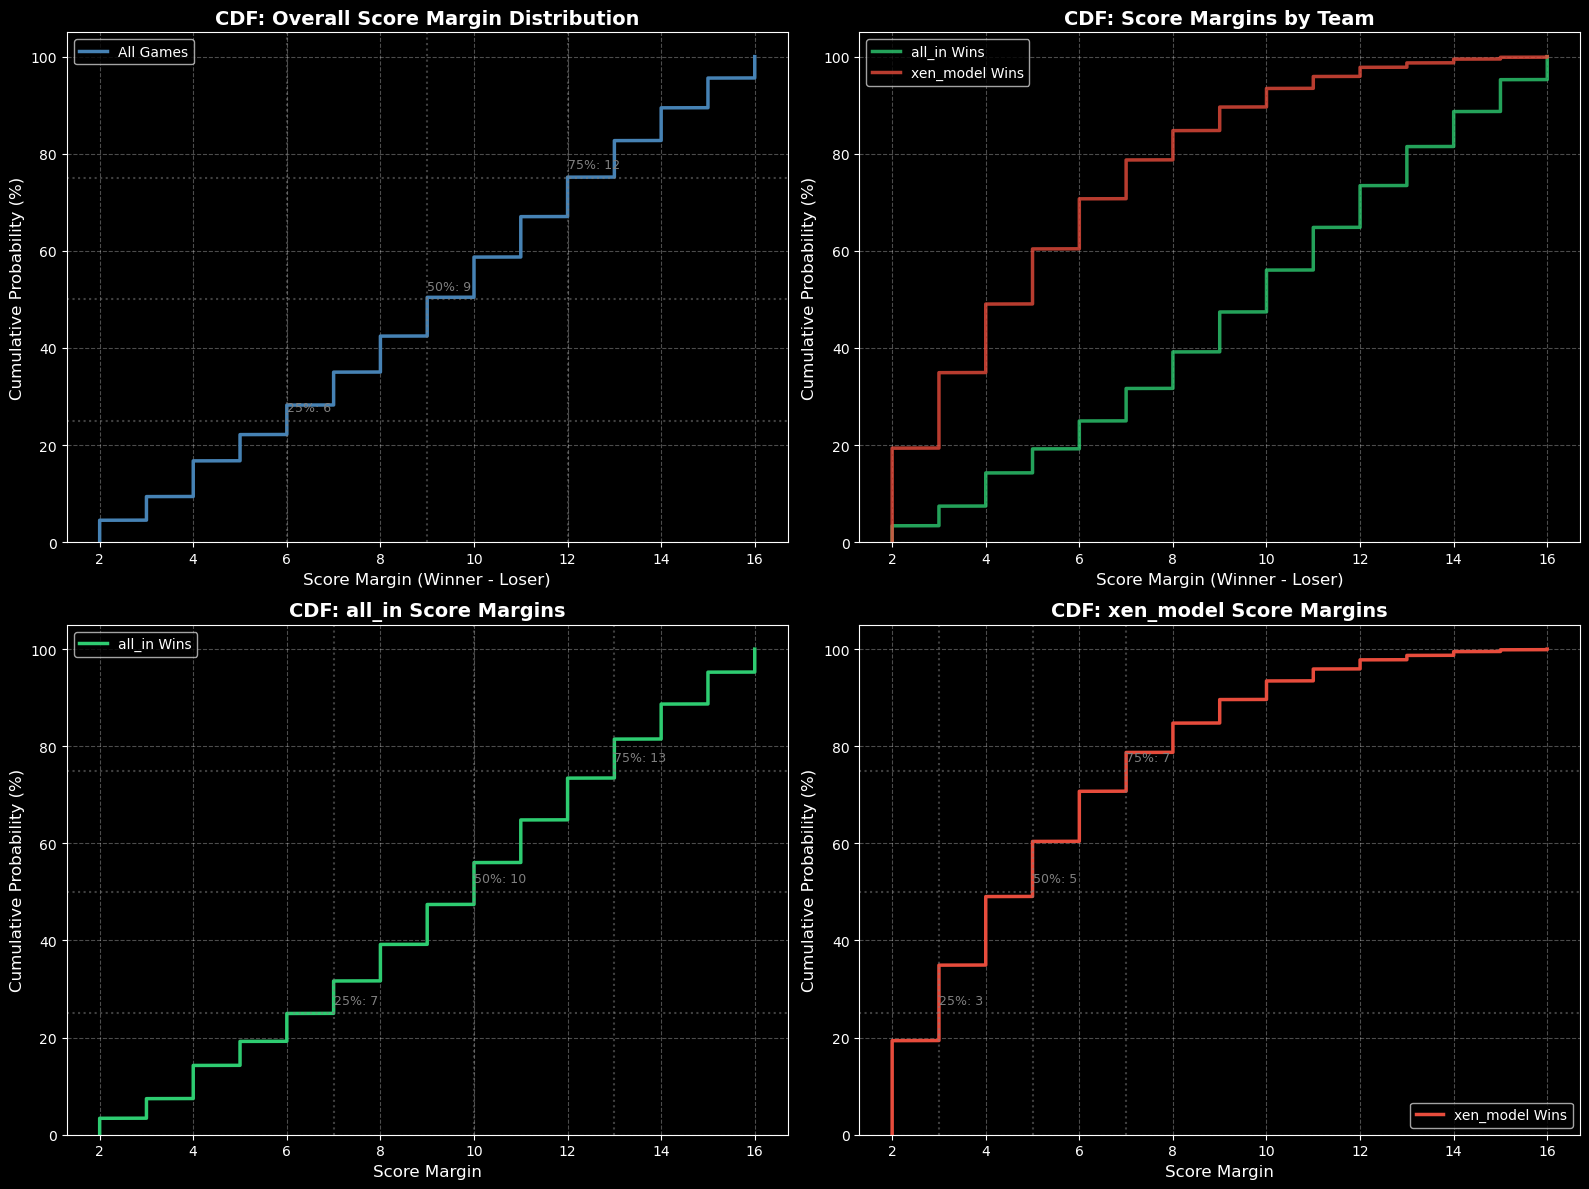


Score Margin CDF Statistics:
Overall Statistics:
  Median margin: 9.0
  25th percentile: 6.0
  75th percentile: 12.0
  Mean margin: 9.22
  Max margin: 16

all_in Wins:
  Median margin: 10.0
  25th percentile: 7.0
  75th percentile: 13.0
  Mean margin: 9.53

xen_model Wins:
  Median margin: 5.0
  25th percentile: 3.0
  75th percentile: 7.0
  Mean margin: 5.27
✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html


In [166]:
# ============================================================================
# CUMULATIVE DISTRIBUTION FUNCTION (CDF) OF SCORE MARGINS
# ============================================================================


# Get final scores for each game
final_scores = df_filtered.groupby('game_id').agg(
    t1_final=('t1_score_end', 'last'),
    t2_final=('t2_score_end', 'last')
).reset_index()

# Create scoreline string for each game (higher score first for canonical)
final_scores['scoreline'] = final_scores.apply(
    lambda row: f"{int(row['t1_final'])}:{int(row['t2_final'])}", 
    axis=1
)

# Determine winner for each scoreline
final_scores['winner'] = final_scores.apply(
    lambda row: t1_label if row['t1_final'] > row['t2_final'] else t2_label, 
    axis=1
)

# Canonical scoreline (winner:loser)
final_scores['canonical_scoreline'] = final_scores.apply(
    lambda row: f"{int(max(row['t1_final'], row['t2_final']))}:{int(min(row['t1_final'], row['t2_final']))}", 
    axis=1
)

# Count occurrences
scoreline_counts = final_scores['scoreline'].value_counts().reset_index()
scoreline_counts.columns = ['scoreline', 'count']
scoreline_counts['percentage'] = (scoreline_counts['count'] / len(final_scores)) * 100

# Team-specific scorelines
t1_scorelines = final_scores[final_scores['winner'] == t1_label]['canonical_scoreline'].value_counts().reset_index()
t1_scorelines.columns = ['scoreline', 'count']
t1_scorelines['percentage'] = (t1_scorelines['count'] / len(final_scores[final_scores['winner'] == t1_label])) * 100

t2_scorelines = final_scores[final_scores['winner'] == t2_label]['canonical_scoreline'].value_counts().reset_index()
t2_scorelines.columns = ['scoreline', 'count']
t2_scorelines['percentage'] = (t2_scorelines['count'] / len(final_scores[final_scores['winner'] == t2_label])) * 100

# Canonical scoreline distribution (overall)
canonical_counts = final_scores['canonical_scoreline'].value_counts().reset_index()
canonical_counts.columns = ['scoreline', 'count']
canonical_counts['percentage'] = (canonical_counts['count'] / len(final_scores)) * 100


# Calculate score margins (winner - loser)
final_scores['score_margin'] = final_scores.apply(
    lambda row: abs(row['t1_final'] - row['t2_final']), 
    axis=1
)

# Calculate score margins for each team (maintaining sign: positive = team wins)
final_scores['t1_margin'] = final_scores['t1_final'] - final_scores['t2_final']
final_scores['t2_margin'] = final_scores['t2_final'] - final_scores['t1_final']

# Overall score margin distribution
overall_margins = final_scores['score_margin'].sort_values()
overall_cdf = np.arange(1, len(overall_margins) + 1) / len(overall_margins) * 100

# Team 1 wins - score margins
t1_wins = final_scores[final_scores['winner'] == t1_label]
t1_margins = t1_wins['score_margin'].sort_values()
t1_cdf = np.arange(1, len(t1_margins) + 1) / len(t1_margins) * 100

# Team 2 wins - score margins
t2_wins = final_scores[final_scores['winner'] == t2_label]
t2_margins = t2_wins['score_margin'].sort_values()
t2_cdf = np.arange(1, len(t2_margins) + 1) / len(t2_margins) * 100

# Create CDF plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Overall CDF of Score Margins
axes[0, 0].plot(overall_margins, overall_cdf, linewidth=2.5, color='steelblue', label='All Games')
axes[0, 0].grid(True, alpha=0.3, linestyle='--')
axes[0, 0].set_xlabel('Score Margin (Winner - Loser)', fontsize=12)
axes[0, 0].set_ylabel('Cumulative Probability (%)', fontsize=12)
axes[0, 0].set_title('CDF: Overall Score Margin Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].set_ylim(0, 105)

# Add reference lines for common percentiles
for pct in [25, 50, 75]:
    idx = int(len(overall_margins) * pct / 100)
    if idx < len(overall_margins):
        margin_val = overall_margins.iloc[idx]
        axes[0, 0].axhline(y=pct, color='gray', linestyle=':', alpha=0.5)
        axes[0, 0].axvline(x=margin_val, color='gray', linestyle=':', alpha=0.5)
        axes[0, 0].text(margin_val, pct + 2, f'{pct}%: {margin_val:.0f}', fontsize=9, color='gray')

# Plot 2: Team-specific CDFs (overlaid)
axes[0, 1].plot(t1_margins, t1_cdf, linewidth=2.5, color='#2ecc71', label=f'{t1_label} Wins', alpha=0.8)
axes[0, 1].plot(t2_margins, t2_cdf, linewidth=2.5, color='#e74c3c', label=f'{t2_label} Wins', alpha=0.8)
axes[0, 1].grid(True, alpha=0.3, linestyle='--')
axes[0, 1].set_xlabel('Score Margin (Winner - Loser)', fontsize=12)
axes[0, 1].set_ylabel('Cumulative Probability (%)', fontsize=12)
axes[0, 1].set_title('CDF: Score Margins by Team', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].set_ylim(0, 105)

# Plot 3: Team 1 CDF with percentile annotations
axes[1, 0].plot(t1_margins, t1_cdf, linewidth=2.5, color='#2ecc71', label=f'{t1_label} Wins')
axes[1, 0].grid(True, alpha=0.3, linestyle='--')
axes[1, 0].set_xlabel('Score Margin', fontsize=12)
axes[1, 0].set_ylabel('Cumulative Probability (%)', fontsize=12)
axes[1, 0].set_title(f'CDF: {t1_label} Score Margins', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].set_ylim(0, 105)

# Add percentile lines for T1
for pct in [25, 50, 75]:
    idx = int(len(t1_margins) * pct / 100)
    if idx < len(t1_margins):
        margin_val = t1_margins.iloc[idx]
        axes[1, 0].axhline(y=pct, color='gray', linestyle=':', alpha=0.5)
        axes[1, 0].axvline(x=margin_val, color='gray', linestyle=':', alpha=0.5)
        axes[1, 0].text(margin_val, pct + 2, f'{pct}%: {margin_val:.0f}', fontsize=9, color='gray')

# Plot 4: Team 2 CDF with percentile annotations
axes[1, 1].plot(t2_margins, t2_cdf, linewidth=2.5, color='#e74c3c', label=f'{t2_label} Wins')
axes[1, 1].grid(True, alpha=0.3, linestyle='--')
axes[1, 1].set_xlabel('Score Margin', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Probability (%)', fontsize=12)
axes[1, 1].set_title(f'CDF: {t2_label} Score Margins', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].set_ylim(0, 105)

# Add percentile lines for T2
for pct in [25, 50, 75]:
    idx = int(len(t2_margins) * pct / 100)
    if idx < len(t2_margins):
        margin_val = t2_margins.iloc[idx]
        axes[1, 1].axhline(y=pct, color='gray', linestyle=':', alpha=0.5)
        axes[1, 1].axvline(x=margin_val, color='gray', linestyle=':', alpha=0.5)
        axes[1, 1].text(margin_val, pct + 2, f'{pct}%: {margin_val:.0f}', fontsize=9, color='gray')

plt.tight_layout()

# Export and display
exporter.export(fig, title="Cumulative Distribution Function - Score Margins")
plt.show()

# Print statistics
print(f"\nScore Margin CDF Statistics:")
print(f"{'='*70}")
print(f"Overall Statistics:")
print(f"  Median margin: {overall_margins.median():.1f}")
print(f"  25th percentile: {overall_margins.quantile(0.25):.1f}")
print(f"  75th percentile: {overall_margins.quantile(0.75):.1f}")
print(f"  Mean margin: {overall_margins.mean():.2f}")
print(f"  Max margin: {overall_margins.max():.0f}")
print(f"\n{t1_label} Wins:")
print(f"  Median margin: {t1_margins.median():.1f}")
print(f"  25th percentile: {t1_margins.quantile(0.25):.1f}")
print(f"  75th percentile: {t1_margins.quantile(0.75):.1f}")
print(f"  Mean margin: {t1_margins.mean():.2f}")
print(f"\n{t2_label} Wins:")
print(f"  Median margin: {t2_margins.median():.1f}")
print(f"  25th percentile: {t2_margins.quantile(0.25):.1f}")
print(f"  75th percentile: {t2_margins.quantile(0.75):.1f}")
print(f"  Mean margin: {t2_margins.mean():.2f}")
print(f"{'='*70}")

# Export text summary
cdf_summary = f"""Score Margin CDF Statistics
{'='*70}
Overall Statistics:
  Median margin: {overall_margins.median():.1f}
  25th percentile: {overall_margins.quantile(0.25):.1f}
  75th percentile: {overall_margins.quantile(0.75):.1f}
  Mean margin: {overall_margins.mean():.2f}
  Max margin: {overall_margins.max():.0f}

{t1_label} Wins:
  Median margin: {t1_margins.median():.1f}
  25th percentile: {t1_margins.quantile(0.25):.1f}
  75th percentile: {t1_margins.quantile(0.75):.1f}
  Mean margin: {t1_margins.mean():.2f}

{t2_label} Wins:
  Median margin: {t2_margins.median():.1f}
  25th percentile: {t2_margins.quantile(0.25):.1f}
  75th percentile: {t2_margins.quantile(0.75):.1f}
  Mean margin: {t2_margins.mean():.2f}
{'='*70}
"""
exporter.export(cdf_summary, title="CDF Summary Statistics")

## Way to win - Calculation & Visualization

Refactored calculation with helper functions for better readability, plus Sankey and Graphviz visualizations.

In [167]:
# ============================================================================
# IMPROVED CALCULATION - Cleaner, more modular code
# ============================================================================

def extract_game_ids(df, team_col, round_num, condition=None):
    """Extract game IDs for specific round outcomes"""
    if condition is None:
        mask = (df[team_col] == True) & (df['round_number'] == round_num)
    else:
        mask = condition & (df['round_number'] == round_num)
    return set(df[mask]['game_id'])

def calculate_branch_counts(parent_games, *filters):
    """Calculate counts for multiple branches from a parent set"""
    results = []
    for filter_games in filters:
        count = len(parent_games & filter_games)
        results.append(count)
    return results

# Extract base round outcomes
print("Extracting game outcomes...")
total_games = df_filtered['game_id'].nunique()

# R1 outcomes
t1_r1_win = extract_game_ids(df_filtered, 'is_t1_winner', 1)
t2_r1_win = set(df_filtered[df_filtered['round_number'] == 1]['game_id']) - t1_r1_win

# R2 outcomes
t1_r2_win = extract_game_ids(df_filtered, 'is_t1_winner', 2)
t2_r2_win = set(df_filtered[df_filtered['round_number'] == 2]['game_id']) - t1_r2_win

# R15 lead/behind (at end of first half)
t1_r15_lead = extract_game_ids(df_filtered, None, 15, 
                               df_filtered['t1_score_end'] > df_filtered['t2_score_end'])
t2_r15_lead = extract_game_ids(df_filtered, None, 15,
                               df_filtered['t2_score_end'] > df_filtered['t1_score_end'])

# R16 outcomes
t1_r16_win = extract_game_ids(df_filtered, 'is_t1_winner', 16)
t2_r16_win = set(df_filtered[df_filtered['round_number'] == 16]['game_id']) - t1_r16_win

# R17 outcomes
t1_r17_win = extract_game_ids(df_filtered, 'is_t1_winner', 17)
t2_r17_win = set(df_filtered[df_filtered['round_number'] == 17]['game_id']) - t1_r17_win

# Final game outcomes
game_scores = df_filtered.groupby('game_id')[['t1_score_end','t2_score_end', 'is_t1_winner', 'round_number']].max()
t1_overall_win = set(game_scores[game_scores['t1_score_end'] > game_scores['t2_score_end']].index)
t2_overall_win = set(game_scores[game_scores['t2_score_end'] > game_scores['t1_score_end']].index)

# ============================================================================
# Calculate all branch counts using helper functions
# ============================================================================

 

# Level 1: R1 split
r1_counts = {
    't1_wins': len(t1_r1_win),
    't2_wins': len(t2_r1_win)
}

# Level 2: R2 outcomes for each R1 branch
t1_r2_branches = calculate_branch_counts(t1_r1_win, t1_r2_win, t2_r2_win)
t2_r2_branches = calculate_branch_counts(t2_r1_win, t2_r2_win, t1_r2_win)

# Level 3: R15 outcomes for each R2 branch
# T1 R1 win -> T1 R2 win
t1r1w_t1r2w = t1_r1_win & t1_r2_win
t1r1w_t1r2w_r15 = calculate_branch_counts(t1r1w_t1r2w, t1_r15_lead, t2_r15_lead)

# T1 R1 win -> T1 R2 loss
t1r1w_t1r2l = t1_r1_win & t2_r2_win
t1r1w_t1r2l_r15 = calculate_branch_counts(t1r1w_t1r2l, t1_r15_lead, t2_r15_lead)

# T2 R1 win -> T2 R2 win
t2r1w_t2r2w = t2_r1_win & t2_r2_win
t2r1w_t2r2w_r15 = calculate_branch_counts(t2r1w_t2r2w, t2_r15_lead, t1_r15_lead)

# T2 R1 win -> T2 R2 loss
t2r1w_t2r2l = t2_r1_win & t1_r2_win
t2r1w_t2r2l_r15 = calculate_branch_counts(t2r1w_t2r2l, t2_r15_lead, t1_r15_lead)

# Level 4: R16 outcomes for each R15 branch
# T1 paths
t1_r16_branches = calculate_branch_counts(t1_r15_lead, t1_r16_win, t2_r16_win)
# T2 paths
t2_r16_branches = calculate_branch_counts(t2_r15_lead, t2_r16_win, t1_r16_win)

#Level 5: R17 outcomes for each R16 Branch
#T1 Path
t1h1l_r16w = t1_r15_lead & t1_r16_win
t1h1l_t1r16w_r17 = calculate_branch_counts(t1h1l_r16w, t1_r17_win, t2_r17_win)

t1h1l_r16l = t1_r15_lead & t2_r16_win
t1h1l_t1r16l_r17 = calculate_branch_counts(t1h1l_r16l, t1_r17_win, t2_r17_win)

#T2 Path
t2h1l_r16w = t2_r15_lead & t2_r16_win
t2h1l_t2r16w_r17 = calculate_branch_counts(t2h1l_r16w, t2_r17_win, t1_r17_win)

t2h1l_r16l = t2_r15_lead & t1_r16_win
t2h1l_t2r16l_r17 = calculate_branch_counts(t2h1l_r16l, t2_r17_win, t1_r17_win)

# Level 5: Final outcomes for each R17 branch
# T1 R2 win paths
t1_final_counts = {
    'r15lead_r16w_r17w': calculate_branch_counts(t1h1l_r16w & t1_r17_win, t1_overall_win, t2_overall_win),
    'r15lead_r16w_r17l': calculate_branch_counts(t1h1l_r16w & t2_r17_win, t1_overall_win, t2_overall_win),
    'r15lead_r16l_r17w': calculate_branch_counts(t1h1l_r16l & t1_r17_win, t1_overall_win, t2_overall_win),
    'r15lead_r16l_r17l': calculate_branch_counts(t1h1l_r16l & t2_r17_win, t1_overall_win, t2_overall_win),
}

# T2 final paths
t2_final_counts = {
    'r15lead_r16w_r17w': calculate_branch_counts(t2h1l_r16w & t2_r17_win, t2_overall_win, t1_overall_win),
    'r15lead_r16w_r17l': calculate_branch_counts(t2h1l_r16w & t1_r17_win, t2_overall_win, t1_overall_win),
    'r15lead_r16l_r17w': calculate_branch_counts(t2h1l_r16l & t2_r17_win, t2_overall_win, t1_overall_win),
    'r15lead_r16l_r17l': calculate_branch_counts(t2h1l_r16l & t1_r17_win, t2_overall_win, t1_overall_win),
}






Extracting game outcomes...


In [168]:
# ============================================================================
# SANKEY DIAGRAM - Interactive flow visualization
# ============================================================================

import plotly.graph_objects as go

def create_sankey_data():
    """Build Sankey diagram source/target/value arrays"""
    
    # Node labels (indexed)
    labels = [
        "All Games",  # 0
        
        # R1 level
        "T1 WIN R1", "T2 WIN R1",  # 1, 2
        
        # R2 level - T1 path
        "T1 WIN R2", "T1 LOSE R2",  # 3, 4
        # R2 level - T2 path
        "T2 WIN R2", "T2 LOSE R2",  # 5, 6
        
        # R15 level - T1 win
        "T1 AHEAD First Half",   # 7, 
        # R15 level - T2 loss
        "T2 AHEAD First Half",   # 8, 
        
        # R16 level - T1 paths (2 nodes)
        "T1 WIN R16", "T1 LOSE R16",  # 9, 10
        
        # R16 level - T2 paths (2 nodes)
        "T2 WIN R16", "T2 LOSE R16",  # 11, 12

        
        # R17 level - T1 paths (4 nodes)
        "T1 WIN R17 (Lead,R16W)", "T1 LOSE R17 (Lead,R16W)",  # 13, 14
        "T1 WIN R17 (Lead,R16L)", "T1 LOSE R17 (Lead,R16L)",  # 15, 16
        
        # R17 level - T2 paths (4 nodes)
        "T2 WIN R17 (Lead,R16W)", "T2 LOSE R17 (Lead,R16W)",  # 17, 18
        "T2 WIN R17 (Lead,R16L)", "T2 LOSE R17 (Lead,R16L)",  # 19, 20

        # Final outcomes - T1 (4 nodes)
        "T1 WIN (R15Lead,R16W,R17W)", #21
        "T1 WIN (R15Lead,R16W,R17L)", #22
        "T1 WIN (R15Lead,R16L,R17W)", #23
        "T1 WIN (R15Lead,R16L,R17L)", #24

        # Final outcomes - T2 (8 nodes)
        "T2 WIN (R15Lead,R16W,R17W)", #25
        "T2 WIN (R15Lead,R16W,R17L)", #26
        "T2 WIN (R15Lead,R16L,R17W)", #27
        "T2 WIN (R15Lead,R16L,R17L)", #28
    ]
    
    sources = []
    targets = []
    values = []
    
    # Root to R1
    sources.extend([0, 0])
    targets.extend([1, 2])
    values.extend([r1_counts['t1_wins'], r1_counts['t2_wins']])
    
    # R1 to R2
    sources.extend([1, 1, 2, 2])
    targets.extend([3, 4, 5, 6])
    values.extend(t1_r2_branches + t2_r2_branches)
    
    # R2 to R15 - Merge paths - Lead
    sources.extend([3, 3, 4, 4, 5, 5, 6, 6])
    targets.extend([7, 8, 7, 8, 8, 7, 8, 7])
    values.extend(t1r1w_t1r2w_r15 + t1r1w_t1r2l_r15 + t2r1w_t2r2w_r15 + t2r1w_t2r2l_r15)
    
    # R15 to R16 
    sources.extend([7, 7, 8, 8])
    targets.extend([9, 10, 11, 12])
    values.extend(t1_r16_branches + t2_r16_branches)
    
    # R16 to R17 - T1 paths
    sources.extend([9, 9, 10, 10])
    targets.extend([13, 14, 15, 16])
    values.extend(t1h1l_t1r16w_r17 + t1h1l_t1r16l_r17)

    # R16 to R17 - T2 paths
    sources.extend([11, 11, 12, 12])
    targets.extend([17, 18, 19, 20])
    values.extend(t2h1l_t2r16w_r17 + t2h1l_t2r16l_r17)
    
    # R17 to Final - T1 paths
    t1_r17_indices = [13, 13, 14, 14, 15, 15, 16, 16]
    t1_final_indices = [21, 25, 22, 26, 23, 27, 24, 28]
    sources.extend(t1_r17_indices)
    targets.extend(t1_final_indices)
    t1_final_values = [v for path_counts in t1_final_counts.values() for v in path_counts]
    values.extend(t1_final_values)
    
    # R16 to Final - T2 paths
    t2_r17_indices = [17, 17, 18, 18, 19, 19, 20, 20]
    t2_final_indices = [25, 21, 26, 22, 27, 23, 28, 24]
    sources.extend(t2_r17_indices)
    targets.extend(t2_final_indices)
    t2_final_values = [v for path_counts in t2_final_counts.values() for v in path_counts]
    values.extend(t2_final_values)
    
    return labels, sources, targets, values

# Create Sankey diagram
print("Building Sankey diagram...")
labels, sources, targets, values = create_sankey_data()

# Color scheme
node_colors = []
for label in labels:
    if "T1 WIN" in label or "T1 AHEAD" in label:
        node_colors.append("rgba(73, 245, 39, 0.8)")  # Green
    elif "T1 LOSE" in label or "T1 BEHIND" in label:
        node_colors.append("rgba(245, 155, 39, 0.8)")  # Orange
    elif "T2 WIN" in label or "T2 AHEAD" in label:
        node_colors.append("rgba(39, 52, 245, 0.8)")  # Blue
    elif "T2 LOSE" in label or "T2 BEHIND" in label:
        node_colors.append("rgba(245, 39, 228, 0.8)")  # Purple
    elif "All Games" in label or "T1" in label or "T2" in label:
        node_colors.append("rgba(39, 245, 232, 0.8)")  # Turquoise
    else:
        node_colors.append("rgba(223, 230, 233, 0.8)")  # Gray

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(200, 200, 200, 0.4)"
    )
)])

fig.update_layout(
    title=dict(
        text="Game Progression Flow - Sankey Diagram<br><sub>Width represents number of games flowing through each path</sub>",
        font=dict(size=20, family="Arial Black")
    ),
    font=dict(size=10),
    height=1200,
    width=1600,
)

fig.show()
exporter.export(fig, title="Game Progression Flow - Sankey Diagram")

# TODO: This graph can be improved. noteably, the last part is very chaotic. 
# Also potentially do not include category lose, instead only use t1 win/t2 win 
# and improve ordering of the bars (t1 top, t2 bottom)

Building Sankey diagram...


✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html


### Heatmap of score progression

In [169]:
# Step 1: Create temporary dataframe - count occurrences per unique round number
round_counts_temp = df_filtered.groupby('round_number').size().reset_index(name='total_occurrences')

# Step 2: Create permanent dataframe - for each round number and scoreline, count occurrences
# Create scoreline column (e.g., "10-5" format)
df_filtered['scoreline'] = df_filtered['t1_score_end'].astype(str) + '-' + df_filtered['t2_score_end'].astype(str)

# Group by round_number and scoreline to get occurrence counts
scoreline_by_round_df = df_filtered.groupby(['round_number', 'scoreline', 't1_score_end', 't2_score_end']).size().reset_index(name='scoreline_occurrences')

# Step 3: Merge with round counts to calculate percentages
scoreline_by_round_df = scoreline_by_round_df.merge(
    round_counts_temp[['round_number', 'total_occurrences']], 
    on='round_number', 
    how='left'
)

# Calculate percentage
scoreline_by_round_df['percentage'] = (scoreline_by_round_df['scoreline_occurrences'] / 
                                        scoreline_by_round_df['total_occurrences'] * 100)

# Sort for better readability
scoreline_by_round_df = scoreline_by_round_df.sort_values(['round_number', 'scoreline_occurrences'], ascending=[True, False])


✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html


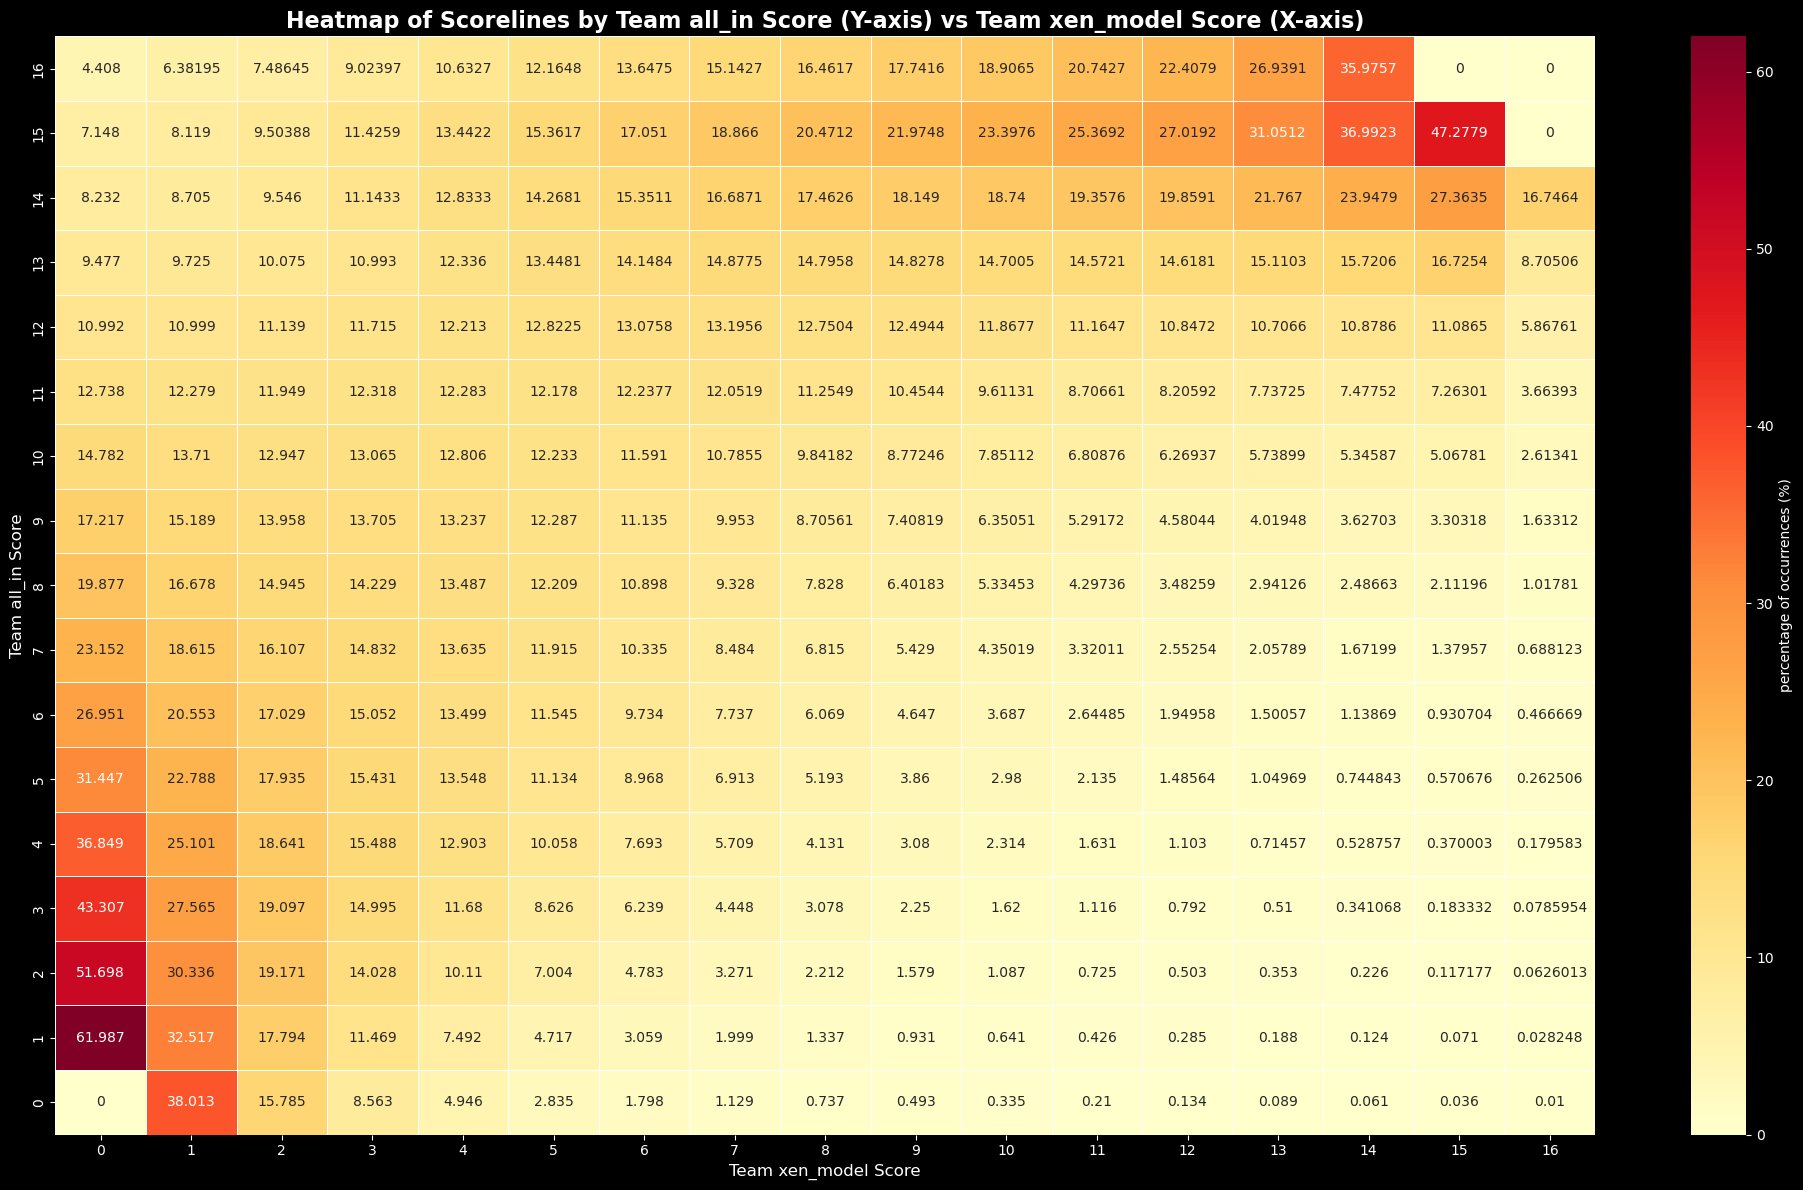

In [170]:
# Create a pivot table for the heatmap
# We'll use round_number as x-axis and scoreline as y-axis, with scoreline_occurrences as values
heatmap_data = scoreline_by_round_df[scoreline_by_round_df['round_number'] < 31][['t1_score_end', 't2_score_end', 'percentage']]

# Create pivot table using t1_score_end and t2_score_end
pivot_data = heatmap_data.pivot_table(
    index='t1_score_end',
    columns='t2_score_end',
    values='percentage',
    aggfunc='sum',
    fill_value=0
)

# Sort by index and columns
pivot_data = pivot_data.sort_index(ascending=False).sort_index(axis=1, ascending=True)

# Create the heatmap
fig = plt.figure(figsize=(20, 12))
sns.heatmap(pivot_data, 
            cmap='YlOrRd', 
            annot=True, 
            fmt='g',
            cbar_kws={'label': 'percentage of occurrences (%)'},
            linewidths=0.5)

plt.title(f'Heatmap of Scorelines by Team {t1_label} Score (Y-axis) vs Team {t2_label} Score (X-axis)', fontsize=16, fontweight='bold')
plt.xlabel(f'Team {t2_label} Score', fontsize=12)
plt.ylabel(f'Team {t1_label} Score', fontsize=12)
plt.tight_layout()

# Export BEFORE showing
exporter.export(fig, title="Scoreline Heatmap - T1 vs T2")
plt.show()

✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html


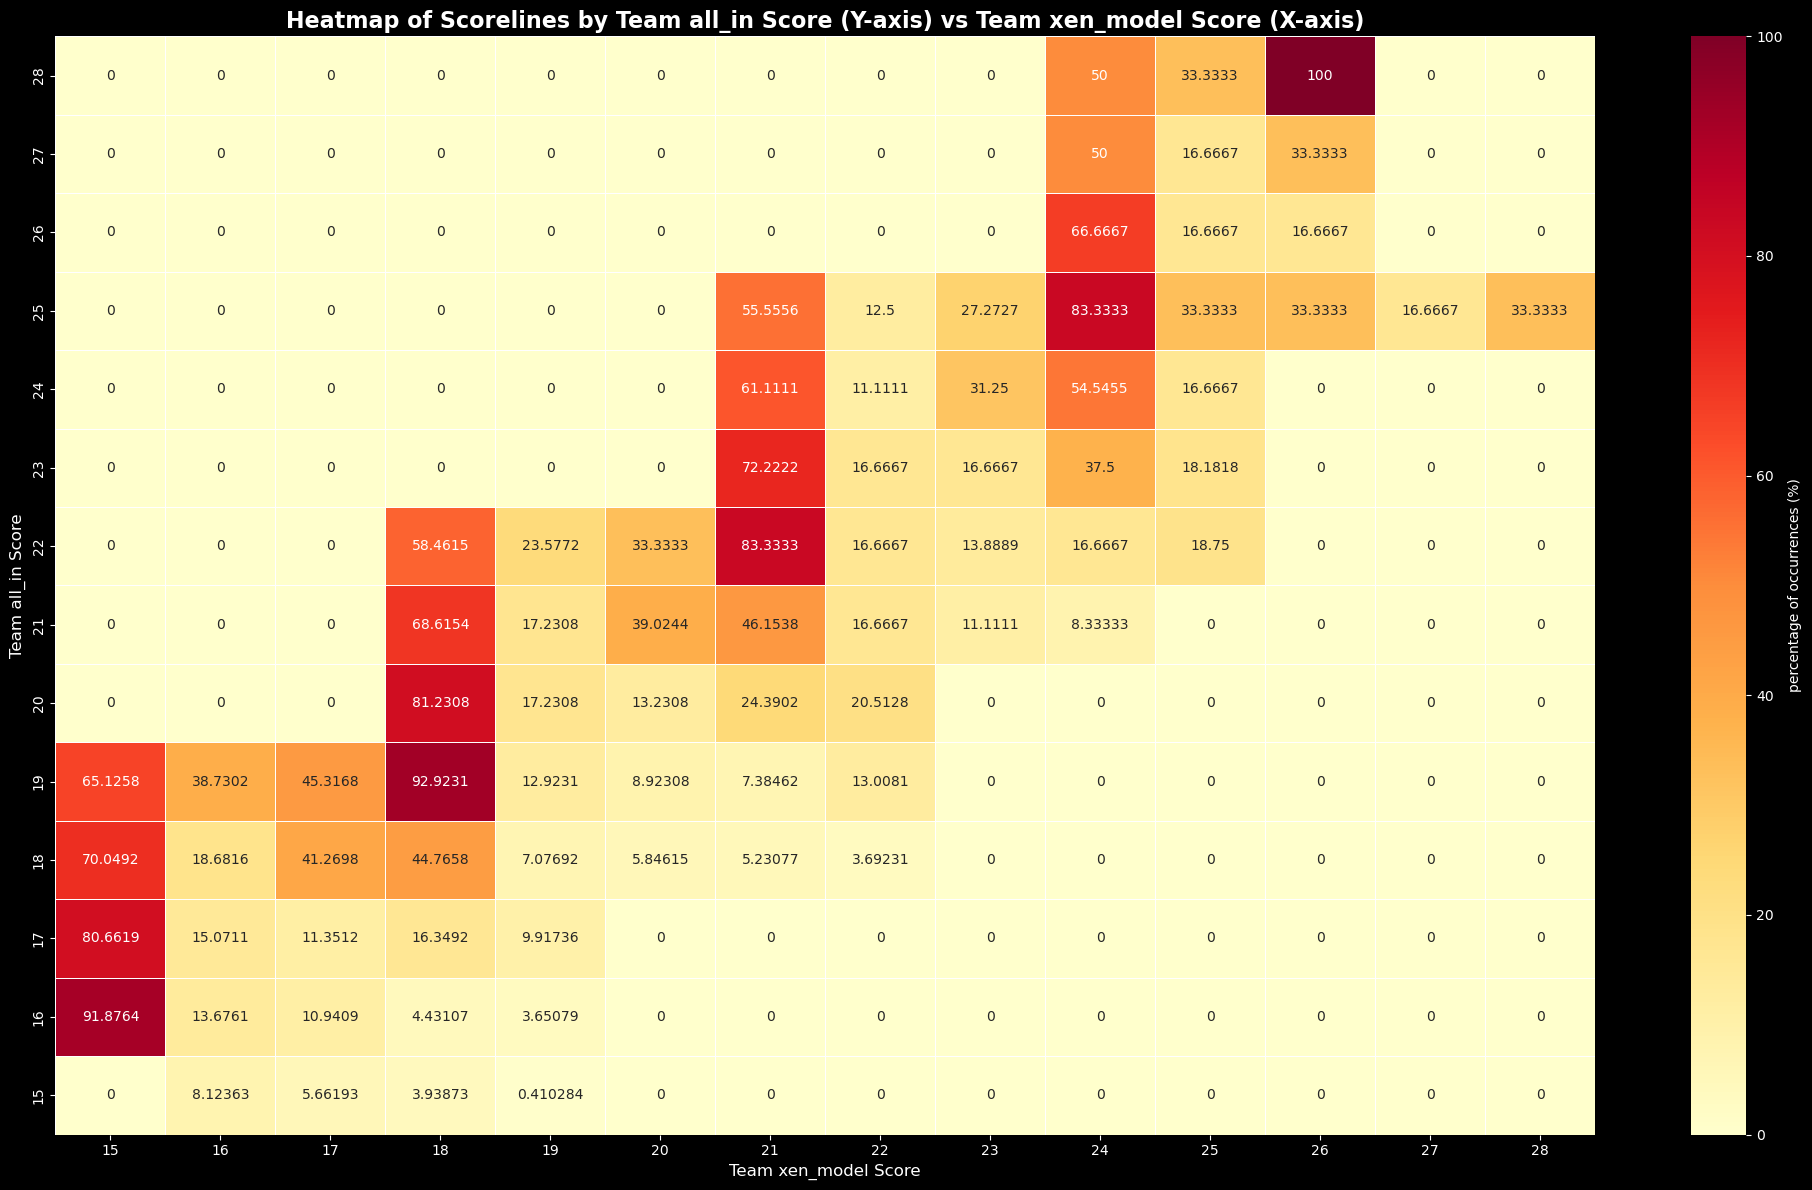

In [171]:
if INCLUDE_OT_GAMES:
    # Create a pivot table for the heatmap
    # We'll use round_number as x-axis and scoreline as y-axis, with scoreline_occurrences as values
    heatmap_data = scoreline_by_round_df[scoreline_by_round_df['round_number'] > 30][['t1_score_end', 't2_score_end', 'percentage']]

    # Create pivot table using t1_score_end and t2_score_end
    pivot_data = heatmap_data.pivot_table(
        index='t1_score_end',
        columns='t2_score_end',
        values='percentage',
        aggfunc='sum',
        fill_value=0
    )

    # Sort by index and columns
    pivot_data = pivot_data.sort_index(ascending=False).sort_index(axis=1, ascending=True)

    # Create the heatmap
    fig = plt.figure(figsize=(20, 12))
    sns.heatmap(pivot_data, 
                cmap='YlOrRd', 
                annot=True, 
                fmt='g',
                cbar_kws={'label': 'percentage of occurrences (%)'},
                linewidths=0.5)

    plt.title(f'Heatmap of Scorelines by Team {t1_label} Score (Y-axis) vs Team {t2_label} Score (X-axis)', fontsize=16, fontweight='bold')
    plt.xlabel(f'Team {t2_label} Score', fontsize=12)
    plt.ylabel(f'Team {t1_label} Score', fontsize=12)
    plt.tight_layout()

    # Export BEFORE showing
    exporter.export(fig, title="OT Scoreline Heatmap - T1 vs T2")
    plt.show()

### progression of all scoreline in sankey
#### TODO: this needs to be fixed, terrible graph

In [172]:
import plotly.graph_objects as go
import re

#TODO: improve node positioning to reduce overlap and improve clarity

# Create scoreline progression data
# For each game, track the scoreline after each round
# df_sorted = df_filtered.sort_values(['game_id', 'round_number'])

# # Build transitions from one round to the next
# transitions = []
# for game_id, game_data in df_sorted.groupby('game_id'):
#     game_data = game_data.sort_values('round_number')
#     prev_scoreline = "Start 0-0"
#     prev_round = 0
    
#     for idx, row in game_data.iterrows():
#         curr_scoreline = f"R{row['round_number']} {row['t1_score_end']}-{row['t2_score_end']}"
#         transitions.append({
#             'source': prev_scoreline,
#             'target': curr_scoreline,
#             'round_from': prev_round,
#             'round_to': row['round_number']
#         })
#         prev_scoreline = curr_scoreline
#         prev_round = row['round_number']

# # Count transitions
# transition_counts = pd.DataFrame(transitions).groupby(['source', 'target']).size().reset_index(name='count')

# # Create node labels (unique scorelines)
# all_nodes = list(set(transition_counts['source'].tolist() + transition_counts['target'].tolist()))

# # Function to extract scores and calculate sort key
# def get_sort_key(node_label):
#     """Extract t1_score and t2_score from node label and return sort key"""
#     if node_label == "Start 0-0":
#         return (0, 0, 0)  # Start in middle
    
#     # Extract round number and scores using regex
#     match = re.match(r"R(\d+)\s+(\d+)-(\d+)", node_label)
#     if match:
#         round_num = int(match.group(1))
#         t1_score = int(match.group(2))
#         t2_score = int(match.group(3))
#         score_diff = t1_score - t2_score  # Positive = T1 winning, Negative = T2 winning
#         return (round_num, -score_diff, t1_score)  # Sort by round, then by score diff (negative for top-to-bottom), then by t1_score
#     return (0, 0, 0)

# # Sort nodes by score difference (higher T1 scores at top, higher T2 scores at bottom)
# all_nodes_with_keys = [(node, get_sort_key(node)) for node in all_nodes]
# all_nodes_with_keys.sort(key=lambda x: x[1])
# all_nodes_sorted = [node for node, key in all_nodes_with_keys]

# Create node dict with sorted order
# node_dict = {node: idx for idx, node in enumerate(all_nodes_sorted)}

# Group nodes by round and assign evenly distributed y-coordinates within each round
# This prevents overlapping

# nodes_by_round = {}
# for node in all_nodes_sorted:
#     round_num, neg_score_diff, t1_score = get_sort_key(node)
#     if round_num not in nodes_by_round:
#         nodes_by_round[round_num] = []
#     nodes_by_round[round_num].append((node, -neg_score_diff))  # Store node with score_diff

# Assign y-coordinates - distribute nodes evenly within each round based on their score diff order
# node_y_coords = []
# node_x_coords = []
# for node in all_nodes_sorted:
#     round_num, neg_score_diff, t1_score = get_sort_key(node)
#     score_diff = -neg_score_diff
    
#     # Get nodes in this round sorted by score difference
#     round_nodes = sorted(nodes_by_round[round_num], key=lambda x: x[1], reverse=True)
#     num_nodes_in_round = len(round_nodes)
    
#     # Find index of current node in this round
#     node_index = next(i for i, (n, sd) in enumerate(round_nodes) if n == node)
    
#     # Distribute nodes evenly from 0 to 1 with padding
#     if num_nodes_in_round == 1:
#         y_coord = 0.5
#     else:
#         # Add padding margins (5% top and bottom)
#         y_coord = 0.05 + (node_index / (num_nodes_in_round - 1)) * 0.9
    
#     node_y_coords.append(y_coord)
    
#     # X-coordinate based on round number
#     if node == "Start 0-0":
#         x_coord = 0.0
#     else:
#         x_coord = round_num / 30  # Normalize to 0-1 range
#     node_x_coords.append(x_coord)

# # Create source, target, value lists for Sankey
# sources = [node_dict[src] for src in transition_counts['source']]
# targets = [node_dict[tgt] for tgt in transition_counts['target']]
# values = transition_counts['count'].tolist()

# Create Sankey diagram with positioned nodes

# fig = go.Figure(data=[go.Sankey(
#     node=dict(
#         pad=5,
#         thickness=10,
#         line=dict(color="black", width=0.5),
#         label=all_nodes_sorted,
#         color="lightblue",
#         x=node_x_coords,
#         y=node_y_coords
#     ),
#     link=dict(
#         source=sources,
#         target=targets,
#         value=values
#     )
# )])

# fig.update_layout(
#     title_text="Scoreline Progression Through All Rounds (Top: T1 Winning, Bottom: T2 Winning)",
#     font_size=10,
#     height=2000,
#     width=2400,
# )
# fig.show()

#  Total unique scorelines: {len(all_nodes_sorted)}")
#  Total transitions: {len(transition_counts)}")

### Round win vs Game win percentage

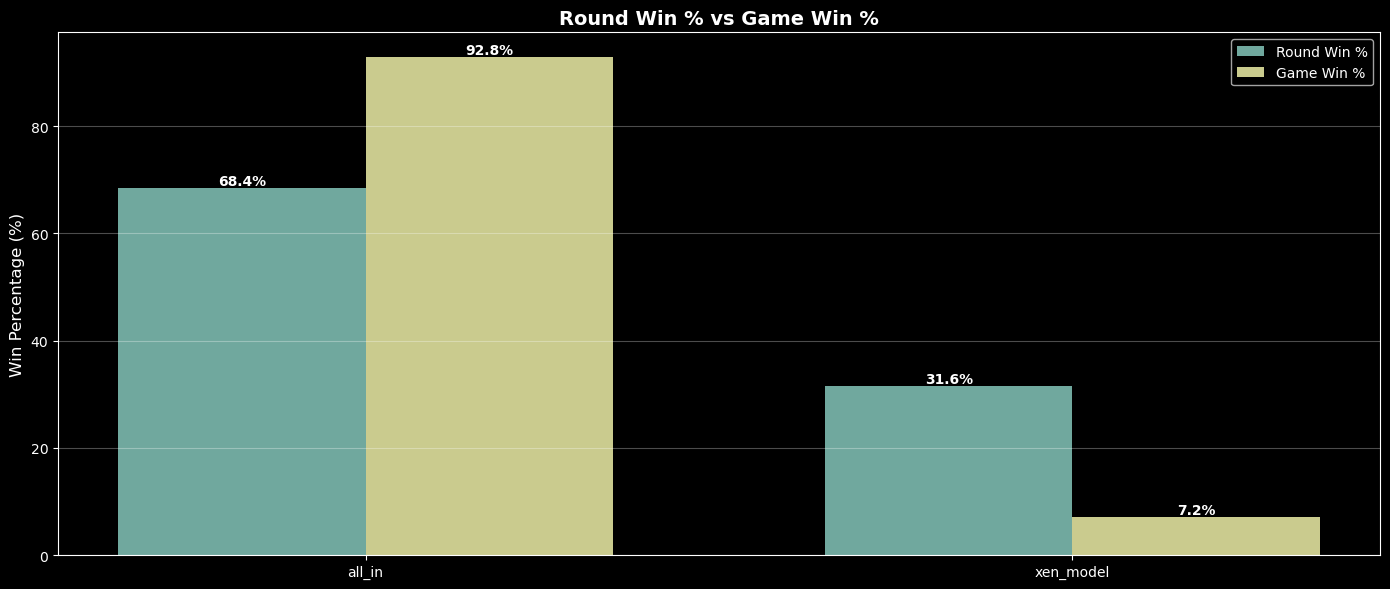

✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html
Round Win vs Game Win Comparison
     Team  Round Win %  Round Wins  Game Win %  Game Wins  Difference (Round - Game %)
   all_in    68.397529     1574362      92.849      92849                   -24.451471
xen_model    31.602471      727420       7.151       7151                    24.451471
✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html


In [173]:
# Calculate round win percentages and game win percentages for both teams

# Round-level statistics
total_rounds = len(df_filtered)
t1_rounds_won = df_filtered['is_t1_winner'].sum()
t2_rounds_won = total_rounds - t1_rounds_won

t1_round_win_pct = (t1_rounds_won / total_rounds) * 100
t2_round_win_pct = (t2_rounds_won / total_rounds) * 100

# Game-level statistics
t1_games_won = len(t1_overall_win)
t2_games_won = len(t2_overall_win)

t1_game_win_pct = (t1_games_won / total_games) * 100
t2_game_win_pct = (t2_games_won / total_games) * 100

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Team': [t1_label, t2_label],
    'Round Win %': [t1_round_win_pct, t2_round_win_pct],
    'Round Wins': [t1_rounds_won, t2_rounds_won],
    'Game Win %': [t1_game_win_pct, t2_game_win_pct],
    'Game Wins': [t1_games_won, t2_games_won],
    'Difference (Round - Game %)': [t1_round_win_pct - t1_game_win_pct, 
                                     t2_round_win_pct - t2_game_win_pct]
})


# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

# Bar chart comparing percentages
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Round Win %'], width, label='Round Win %', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Game Win %'], width, label='Game Win %', alpha=0.8)

ax.set_ylabel('Win Percentage (%)', fontsize=12)
ax.set_title('Round Win % vs Game Win %', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Team'])
ax.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()



# Add value labels on bars
for bars in [bars1, bars2]:# Calculate expenditure and FTE equipment when winning a round for both teams

    # For T1: rounds where T1 won
    t1_win_rounds = df_filtered[df_filtered['is_t1_winner'] == True].copy()
    t1_spent_on_win = t1_win_rounds['t1_spent']
    t1_ratio_on_win = t1_win_rounds['t1_spent'] / (t1_win_rounds['t1_spent'] + t1_win_rounds['t2_spent'])
    t1_fte_on_win = t1_win_rounds['t1_fte_eq']

    t1_fte_ratio_on_win = t1_win_rounds['t1_fte_eq'] / (t1_win_rounds['t1_fte_eq'] + t1_win_rounds['t2_fte_eq'])
    # For T2: rounds where T2 won
    t2_win_rounds = df_filtered[df_filtered['is_t1_winner'] == False].copy()
    t2_spent_on_win = t2_win_rounds['t2_spent']
    t2_ratio_on_win = t2_win_rounds['t2_spent'] / (t2_win_rounds['t1_spent'] + t2_win_rounds['t2_spent'])
    t2_fte_on_win = t2_win_rounds['t2_fte_eq']

plt.show()
exporter.export(fig, title="Round Win % vs Game Win %")

# Export comparison stats
comparison_text = f"""Round Win vs Game Win Comparison
{'='*80}
{comparison_df.to_string(index=False)}
{'='*80}"""

print(comparison_text)

exporter.export(comparison_text, title="Round vs Game Win Statistics")

### Spenditure on win compared to own 

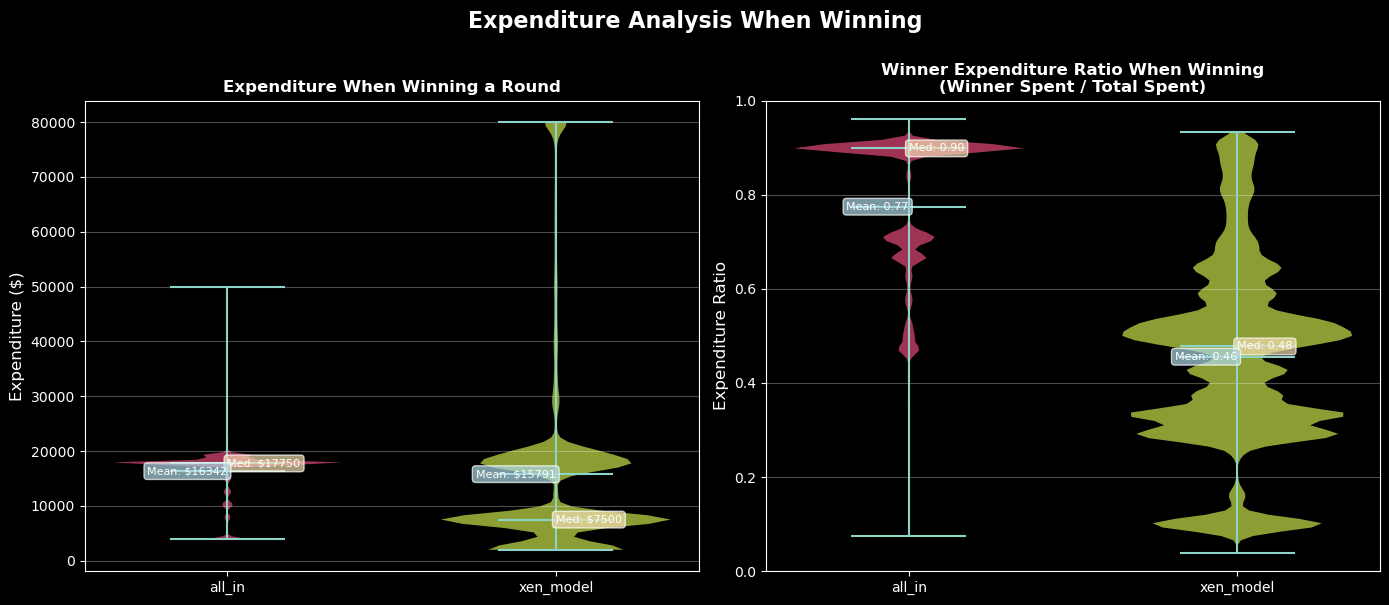

✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html
✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html
Expenditure and FTE When Winning - Summary================================================================================

================================================================================  FTE Ratio: Mean=0.532, Median=0.545

all_in When Winning:  FTE Equipment: Mean=$29100.29, Median=$21000.00

  Expenditure: Mean=$16342.37, Median=$17750.00  Exp. Ratio: Mean=0.456, Median=0.478

  Exp. Ratio: Mean=0.775, Median=0.899  Expenditure: Mean=$15790.76, Median=$7500.00

  FTE Equipment: Mean=$29427.62, Median=$29708.00xen_model When Winning:

  FTE Ratio: Mean=0.774, Median=0.880
✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html


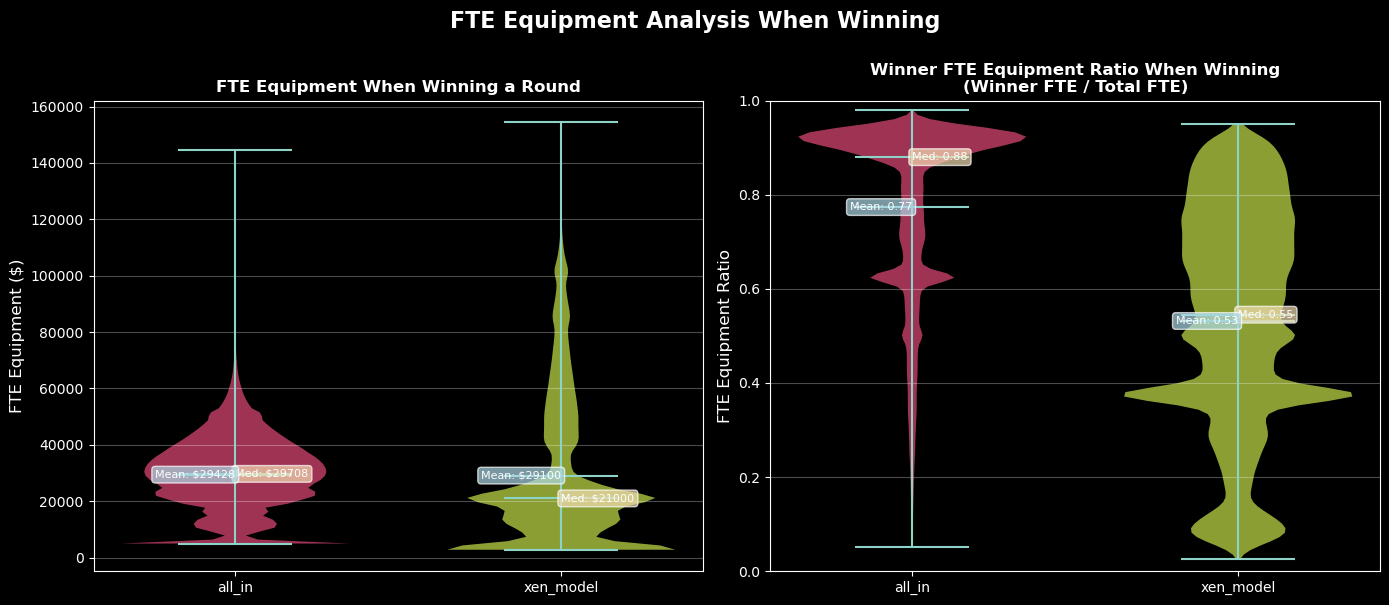

In [174]:
# Calculate expenditure and FTE equipment when winning a round for both teams

# For T1: rounds where T1 won
t1_win_rounds = df_filtered[df_filtered['is_t1_winner'] == True].copy()
t1_spent_on_win = t1_win_rounds['t1_spent']
t1_ratio_on_win = t1_win_rounds['t1_spent'] / (t1_win_rounds['t1_spent'] + t1_win_rounds['t2_spent'])
t1_fte_on_win = t1_win_rounds['t1_fte_eq']
t1_fte_ratio_on_win = t1_win_rounds['t1_fte_eq'] / (t1_win_rounds['t1_fte_eq'] + t1_win_rounds['t2_fte_eq'])

# For T2: rounds where T2 won
t2_win_rounds = df_filtered[df_filtered['is_t1_winner'] == False].copy()
t2_spent_on_win = t2_win_rounds['t2_spent']
t2_ratio_on_win = t2_win_rounds['t2_spent'] / (t2_win_rounds['t1_spent'] + t2_win_rounds['t2_spent'])
t2_fte_on_win = t2_win_rounds['t2_fte_eq']
t2_fte_ratio_on_win = t2_win_rounds['t2_fte_eq'] / (t2_win_rounds['t1_fte_eq'] + t2_win_rounds['t2_fte_eq'])

# ============================================================================
# FIGURE 1: EXPENDITURE WHEN WINNING - VIOLIN PLOTS
# ============================================================================

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Prepare data for violin plots
spent_data = pd.DataFrame({
    'Expenditure': pd.concat([t1_spent_on_win, t2_spent_on_win]),
    'Team': [t1_label]*len(t1_spent_on_win) + [t2_label]*len(t2_spent_on_win)
})

ratio_data = pd.DataFrame({
    'Ratio': pd.concat([t1_ratio_on_win, t2_ratio_on_win]),
    'Team': [t1_label]*len(t1_ratio_on_win) + [t2_label]*len(t2_ratio_on_win)
})

# Left plot: Expenditure amounts
parts1 = ax1.violinplot([t1_spent_on_win, t2_spent_on_win],
                         positions=[0, 1],
                         showmeans=True,
                         showmedians=True,
                         widths=0.7)

# Color the violin plots
colors = ["#E24A77","#C6E24A",'#4A90E2', '#50C878']
for i, pc in enumerate(parts1['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

ax1.set_xticks([0, 1])
ax1.set_xticklabels([t1_label, t2_label])
ax1.set_ylabel('Expenditure ($)', fontsize=12)
ax1.set_title('Expenditure When Winning a Round', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add median and mean annotations
for i, data in enumerate([t1_spent_on_win, t2_spent_on_win]):
    median = data.median()
    mean = data.mean()
    ax1.text(i, median, f'Med: ${median:.0f}', 
             ha='left', va='center', fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    ax1.text(i, mean, f'Mean: ${mean:.0f}', 
             ha='right', va='center', fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# Right plot: Expenditure ratios
parts2 = ax2.violinplot([t1_ratio_on_win, t2_ratio_on_win],
                         positions=[0, 1],
                         showmeans=True,
                         showmedians=True,
                         widths=0.7)

# Color the violin plots
for i, pc in enumerate(parts2['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

ax2.set_xticks([0, 1])
ax2.set_xticklabels([t1_label, t2_label])
ax2.set_ylabel('Expenditure Ratio', fontsize=12)
ax2.set_title('Winner Expenditure Ratio When Winning\n(Winner Spent / Total Spent)', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

# Add median and mean annotations
for i, data in enumerate([t1_ratio_on_win, t2_ratio_on_win]):
    median = data.median()
    mean = data.mean()
    ax2.text(i, median, f'Med: {median:.2f}', 
             ha='left', va='center', fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    ax2.text(i, mean, f'Mean: {mean:.2f}', 
             ha='right', va='center', fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

fig1.suptitle('Expenditure Analysis When Winning', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()
exporter.export(fig1, title="Expenditure Analysis When Winning")

# ============================================================================
# FIGURE 2: FTE EQUIPMENT WHEN WINNING - VIOLIN PLOTS
# ============================================================================

fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: FTE Equipment amounts
parts3 = ax3.violinplot([t1_fte_on_win, t2_fte_on_win],
                         positions=[0, 1],
                         showmeans=True,
                         showmedians=True,
                         widths=0.7)

# Color the violin plots
for i, pc in enumerate(parts3['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

ax3.set_xticks([0, 1])
ax3.set_xticklabels([t1_label, t2_label])
ax3.set_ylabel('FTE Equipment ($)', fontsize=12)
ax3.set_title('FTE Equipment When Winning a Round', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add median and mean annotations
for i, data in enumerate([t1_fte_on_win, t2_fte_on_win]):
    median = data.median()
    mean = data.mean()
    ax3.text(i, median, f'Med: ${median:.0f}', 
             ha='left', va='center', fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    ax3.text(i, mean, f'Mean: ${mean:.0f}', 
             ha='right', va='center', fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# Right plot: FTE Equipment ratios
parts4 = ax4.violinplot([t1_fte_ratio_on_win, t2_fte_ratio_on_win],
                         positions=[0, 1],
                         showmeans=True,
                         showmedians=True,
                         widths=0.7)

# Color the violin plots
for i, pc in enumerate(parts4['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

ax4.set_xticks([0, 1])
ax4.set_xticklabels([t1_label, t2_label])
ax4.set_ylabel('FTE Equipment Ratio', fontsize=12)
ax4.set_title('Winner FTE Equipment Ratio When Winning\n(Winner FTE / Total FTE)', fontsize=12, fontweight='bold')
ax4.set_ylim(0, 1)
ax4.grid(axis='y', alpha=0.3)

# Add median and mean annotations
for i, data in enumerate([t1_fte_ratio_on_win, t2_fte_ratio_on_win]):
    median = data.median()
    mean = data.mean()
    ax4.text(i, median, f'Med: {median:.2f}', 
             ha='left', va='center', fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    ax4.text(i, mean, f'Mean: {mean:.2f}', 
             ha='right', va='center', fontsize=8, 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

fig2.suptitle('FTE Equipment Analysis When Winning', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
exporter.export(fig2, title="FTE Equipment Analysis When Winning")






winning_stats_text = f"""Expenditure and FTE When Winning - Summary{'='*80}

{'='*80}  FTE Ratio: Mean={t2_fte_ratio_on_win.mean():.3f}, Median={t2_fte_ratio_on_win.median():.3f}

{t1_label} When Winning:  FTE Equipment: Mean=${t2_fte_on_win.mean():.2f}, Median=${t2_fte_on_win.median():.2f}

  Expenditure: Mean=${t1_spent_on_win.mean():.2f}, Median=${t1_spent_on_win.median():.2f}  Exp. Ratio: Mean={t2_ratio_on_win.mean():.3f}, Median={t2_ratio_on_win.median():.3f}

  Exp. Ratio: Mean={t1_ratio_on_win.mean():.3f}, Median={t1_ratio_on_win.median():.3f}  Expenditure: Mean=${t2_spent_on_win.mean():.2f}, Median=${t2_spent_on_win.median():.2f}

  FTE Equipment: Mean=${t1_fte_on_win.mean():.2f}, Median=${t1_fte_on_win.median():.2f}{t2_label} When Winning:

  FTE Ratio: Mean={t1_fte_ratio_on_win.mean():.3f}, Median={t1_fte_ratio_on_win.median():.3f}"""

print(winning_stats_text)
exporter.export(winning_stats_text, title="Expenditure and FTE When Winning - Summary")

## Create stats on streaks and reversals

max streak length can be calculated as follows: look where the winner has a consecutivewin_start = 0 -> reversal round


Wald-Wolfowitz runs test could be applied here or the KS test to compare distributions
Another method: pandas.series.autocorr

In [175]:
halftime = sim_summary['simulation_config']['game_rules']['halfLength']

# T1 streaks ending due to loss after win streak or at halftime or game end
t1_streaks_end = df_filtered[
    ((df_filtered['t1_consecutive_losses_start'] == 0) & 
    (df_filtered['t1_consecutive_losses'] == 1) & df_filtered['t1_consecutive_wins_start'] > 0) | 
    ((df_filtered['round_number'] == halftime) &
    (df_filtered['t1_consecutive_wins'] > 0))
]

winner_last_round_data = df_filtered.merge(
    game_scores[['round_number']],  # Select the round_number column from game_scores
    on=['game_id', 'round_number'],
    how='inner'
)

t1_streaks_end = pd.concat([t1_streaks_end, winner_last_round_data[winner_last_round_data['is_t1_winner'] == True]]).drop_duplicates(keep=False)

# T2 streaks ending due to loss after win streak or at halftime or game end
t2_streaks_end = df_filtered[
    ((df_filtered['t2_consecutive_losses_start'] == 0) & 
    (df_filtered['t2_consecutive_losses'] == 1) & (df_filtered['t2_consecutive_wins_start'] > 0)) | 
    ((df_filtered['round_number'] == halftime) &
    (df_filtered['t2_consecutive_wins'] > 0))
]

t2_streaks_end = pd.concat([t2_streaks_end, winner_last_round_data[winner_last_round_data['is_t1_winner'] == False]]).drop_duplicates(keep=False)






In [176]:
# Merging Streak data to form one dataframe of the reversals, halftime and game end

# Add is_t1_streak column to identify which team's streak ended
t1_streaks_end['is_t1_streak'] = True
t2_streaks_end['is_t1_streak'] = False

# Combine both streak dataframes
game_reversals = pd.concat([t1_streaks_end, t2_streaks_end])

# Sort by game_id and round_number for better readability
game_reversals = game_reversals.sort_values(['game_id', 'round_number']).reset_index(drop=True)

# print(game_reversals[game_reversals['game_id'] == random_game_id])

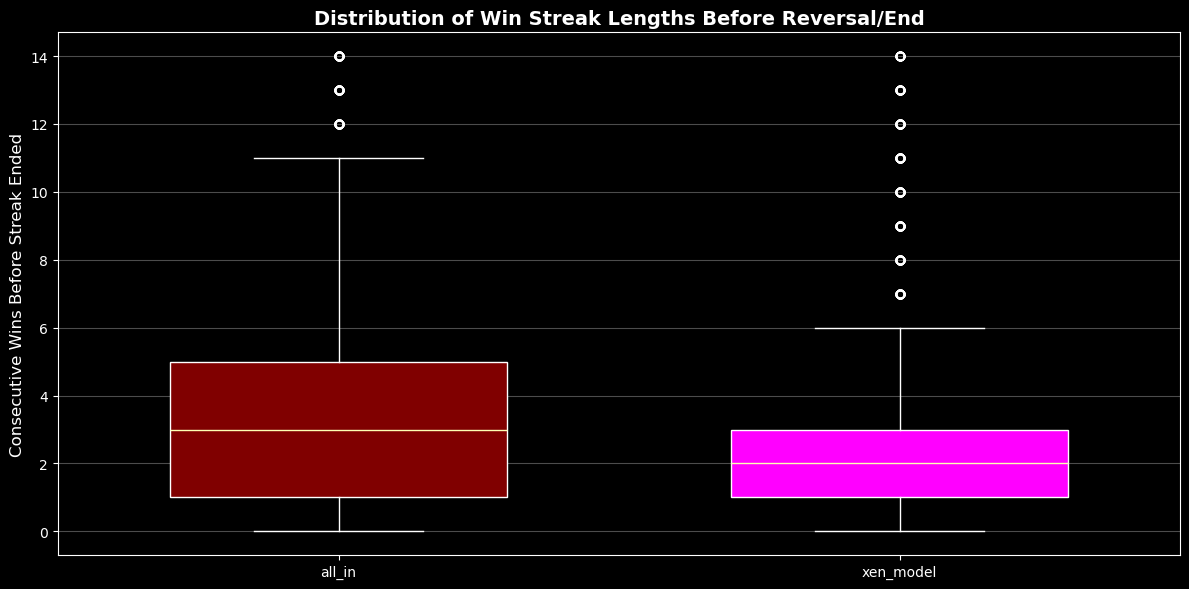

✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html


In [177]:
# Create boxplot for T1 win streaks that ended
fig, ax = plt.subplots(figsize=(12, 6))

# Create side-by-side boxplots
bp = ax.boxplot([t1_streaks_end['t1_consecutive_wins_start'], t2_streaks_end['t2_consecutive_wins_start']], 
    tick_labels=[t1_label, t2_label],
    patch_artist=True,
    widths=0.6)

# Color the boxes
colors = ['maroon', 'fuchsia']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)


ax.set_ylabel('Consecutive Wins Before Streak Ended', fontsize=12)
ax.set_title('Distribution of Win Streak Lengths Before Reversal/End', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

exporter.export(fig, title="Win Streak Lengths Before Reversal/End")

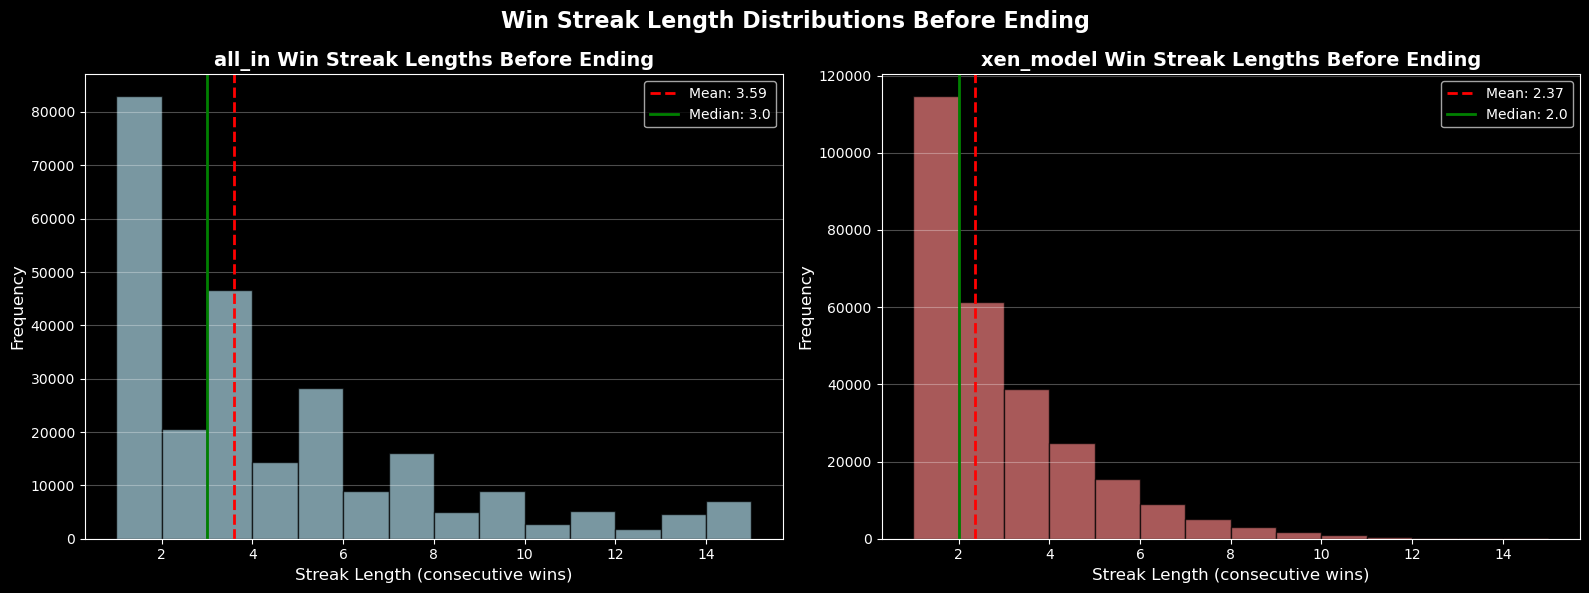


all_in streaks: Count=283833, Mean=3.59, Median=3.0, Std=3.46

xen_model streaks: Count=286887, Mean=2.37, Median=2.0, Std=1.87
✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html
✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html


In [178]:
# Extract streak lengths from the dataframes
t1_streaks_ends = t1_streaks_end[t1_streaks_end['is_t1_streak'] == True]['t1_consecutive_wins_start'].values
t2_streaks_ends = t2_streaks_end[t2_streaks_end['is_t1_streak'] == False]['t2_consecutive_wins_start'].values

# Create histograms
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# T1 histogram
axes[0].hist(t1_streaks_ends, bins=range(1, int(max(t1_streaks_ends))+2), 
             alpha=0.7, color='lightblue', edgecolor='black')
axes[0].set_xlabel('Streak Length (consecutive wins)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title(f'{t1_label} Win Streak Lengths Before Ending', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add statistics text
t1_mean = t1_streaks_ends.mean()
t1_median = np.median(t1_streaks_ends)
axes[0].axvline(t1_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {t1_mean:.2f}')
axes[0].axvline(t1_median, color='green', linestyle='-', linewidth=2, label=f'Median: {t1_median:.1f}')
axes[0].legend()

# T2 histogram
axes[1].hist(t2_streaks_ends, bins=range(1, int(max(t2_streaks_ends))+2), 
             alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Streak Length (consecutive wins)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'{t2_label} Win Streak Lengths Before Ending', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add statistics text
t2_mean = t2_streaks_ends.mean()
t2_median = np.median(t2_streaks_ends)
axes[1].axvline(t2_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {t2_mean:.2f}')
axes[1].axvline(t2_median, color='green', linestyle='-', linewidth=2, label=f'Median: {t2_median:.1f}')
axes[1].legend()

fig.suptitle('Win Streak Length Distributions Before Ending', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

t1_text = f"""\n{t1_label} streaks: Count={len(t1_streaks_ends)}, Mean={t1_mean:.2f}, Median={t1_median:.1f}, Std={t1_streaks_ends.std():.2f}"""
t2_text = f"""\n{t2_label} streaks: Count={len(t2_streaks_ends)}, Mean={t2_mean:.2f}, Median={t2_median:.1f}, Std={t2_streaks_ends.std():.2f}"""

print(t1_text)
print(t2_text)

exporter.export(fig, title="Win Streak Length Distributions Before Ending")
exporter.export(t1_text + t2_text, title="Win Streak Length Statistics Before Ending")

In [179]:
# # Exporting all output to PDF report

# from datetime import datetime
# import os
# import subprocess

# # Skip export if running in batch mode (batch script handles export)
# if 'MATCHUP_FOLDER' not in os.environ:
    
    
    
#     t1_strat = sim_summary['simulation_config']['team1_strategy']
#     t2_strat = sim_summary['simulation_config']['team2_strategy']

#     # Generate timestamp for unique filename
#     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#     output_filename = f"{FOLDER_PATH}\\analysis_report_{timestamp}_{t1_strat}_vs_{t2_strat}.pdf"

#     # Export notebook to PDF without code cells
#     # Convert notebook to HTML without code cells
#     notebook_path = os.path.abspath("analysis_notebook_v2.ipynb")
#     try:
#         subprocess.run([
#             'jupyter', 'nbconvert', 
#             '--to', 'html', 
#             '--no-input', 
#             notebook_path,
#             '--output-dir', FOLDER_PATH,
#             '--output', os.path.splitext(os.path.basename(output_filename))[0]
#         ], check=True)
#          ✓ Report exported successfully to {output_filename}")
#     except subprocess.CalledProcessError as e:
#          ✗ Export failed: {e}")
#     except FileNotFoundError:
#          ✗ jupyter nbconvert not found. Install with: pip install nbconvert")
    
# else:
#      Batch mode: Export handled by batch script")



## Statistical Significance Tests for Game Wins



In [180]:
#first create a list all games with t1_winner true/false

game_scores['t1_winner'] = game_scores['t1_score_end'] > game_scores['t2_score_end']
game_scores['t1_winner_int'] = game_scores['t1_winner'].astype(int)


signed_values_pos = np.sum(game_scores['t1_winner'] == True)
signed_values_neg = np.sum(game_scores['t1_winner'] == False)
print(f"winrate team1: {signed_values_pos/(signed_values_pos+signed_values_neg)} ")
n = np.min([signed_values_pos, signed_values_neg])

signed_test = stats.binomtest(n, n=signed_values_pos + signed_values_neg, p=0.5, alternative='two-sided')
binom_test = stats.binomtest(signed_values_pos, n=signed_values_pos+signed_values_neg)
wilcoxon_test_scores = stats.wilcoxon(game_scores['t1_score_end'], game_scores['t2_score_end'])
wilcoxon_test_outcome = stats.wilcoxon(game_scores['t1_winner_int'])
ttest_related = stats.ttest_rel(game_scores['t1_score_end'], game_scores['t2_score_end'])
f_test = stats.f_oneway(game_scores['t1_score_end'], game_scores['t2_score_end'])
mw_test = stats.mannwhitneyu(game_scores['t1_score_end'], game_scores['t2_score_end'])
ks_test = stats.ks_2samp(game_scores['t1_score_end'], game_scores['t2_score_end'])


tests = {
    'Signed Test': signed_test.pvalue,
    'Binomial Test': binom_test.pvalue,
    'Wilcoxon (Scores)': wilcoxon_test_scores.pvalue,
    'Wilcoxon (Outcome)': wilcoxon_test_outcome.pvalue,
    'Paired t-test': ttest_related.pvalue,
    'F-test': f_test.pvalue,
    'Mann-Whitney U': mw_test.pvalue,
    'Kolmogorov-Smirnov': ks_test.pvalue,
}

alpha = 0.005

# Check if ALL tests are significant
significance = all(p < alpha for p in tests.values())



text_output_tests = f"""Statistical Significance Test Results
{'='*80}
"""

for test_name, p_value in tests.items():
    status = "✓ SIGNIFICANT" if p_value < alpha else "✗ NOT SIGNIFICANT"
    text_output_tests += f"{test_name:.<40} p={p_value:.6f} {status}\n"

text_output_tests += f"""{'='*80}
"""

print (text_output_tests)
exporter.export(text_output_tests, title="Statistical Significance Test Results")



winrate team1: 0.92849 
Statistical Significance Test Results
Signed Test............................. p=0.000000 ✓ SIGNIFICANT
Binomial Test........................... p=0.000000 ✓ SIGNIFICANT
Wilcoxon (Scores)....................... p=0.000000 ✓ SIGNIFICANT
Wilcoxon (Outcome)...................... p=0.000000 ✓ SIGNIFICANT
Paired t-test........................... p=0.000000 ✓ SIGNIFICANT
F-test.................................. p=0.000000 ✓ SIGNIFICANT
Mann-Whitney U.......................... p=0.000000 ✓ SIGNIFICANT
Kolmogorov-Smirnov...................... p=0.000000 ✓ SIGNIFICANT

✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html


In [181]:
def find_significant_winrate(n, alpha=0.005):
    """
    Find the minimum winrate that is statistically significantly different 
    from 50% at a given significance level (alpha) for n simulations.
    
    Parameters:
    -----------
    n : int
        Number of simulations (sample size)
    alpha : float
        Significance level (default 0.005 for two-tailed test)
    
    Returns:
    --------
    dict with keys:
        - 'critical_wins': minimum wins needed for significance
        - 'critical_winrate': as percentage
        - 'minimum_difference': from 50% (in percentage points)
        - 'p_value': exact p-value at critical point
    """
    from scipy.stats import binomtest
    
    # Find critical value by testing each possible win count
    # Start from 50% and increase until we find significance
    critical_wins = None
    
    for k in range(n // 2, n + 1):
        p_value = binomtest(k, n, 0.5, alternative='two-sided').pvalue
        if p_value <= alpha:
            critical_wins = k
            critical_pvalue = p_value
            break
    
    if critical_wins is None:
        # No significant difference possible at this alpha with this n
        return {
            'critical_wins': None,
            'critical_winrate': None,
            'minimum_difference': None,
            'p_value': None,
            'message': f'No significant difference possible at α={alpha} with n={n}'
        }
    
    winrate_pct = (critical_wins / n) * 100
    min_diff_pct = abs(winrate_pct - 50)
    
    return {
        'critical_wins': critical_wins,
        'critical_winrate': winrate_pct,
        'minimum_difference': min_diff_pct,
        'p_value': critical_pvalue,
        'n': n,
        'alpha': alpha
    }


# Calculate for current dataset
alpha_level = 0.005
current_result = find_significant_winrate(int(total), alpha=alpha_level)

text_minimal_winrate = f"""Statistical Significance Winrate Analysis
{'='*80}
Current Dataset (n={int(total)}):
α = {alpha_level} (two-tailed)
Minimum wins for significance: {current_result['critical_wins']}
Minimum winrate: {current_result['critical_winrate']:.2f}%
Minimum difference from 50%: ±{current_result['minimum_difference']:.2f}%
P-value at critical point: {current_result['p_value']:.6f}
{'='*80}"""


print(text_minimal_winrate)
exporter.export(text_minimal_winrate, title="Statistical Significance Winrate Analysis")




Statistical Significance Winrate Analysis
Current Dataset (n=100000):
α = 0.005 (two-tailed)
Minimum wins for significance: 50445
Minimum winrate: 50.44%
Minimum difference from 50%: ±0.44%
P-value at critical point: 0.004934
✓ Exported to results_20260127_143906\analysis_report_20260127_143958_all_in_vs_xen_model.html
